# Peer-graded Assignment: Построение и оптимизация моделей

Итак, мы научились обрабатывать данные, выбрали схему кросс-валидации и определились с метриками качества. Пора переходить к оптимизации модели. На этой неделе вам предстоит принять участие в соревновании на платформе kaggle inclass! Цель такого соревнования - преодолеть предложенное baseline решение, а, главное, обсудить и сравнить предложенные решения на форуме. Какие признаки оказали наибольший вклад в модель? Как лучше обрабатывать категориальные признаки? Нужно ли делать отбор признаков, А балансировать выборку? Экспериментируйте с данными и обсуждайте ваши решения на форуме!

### Инструкции

В этом задании вам предстоит поучаствовать в соревновании на kaggle inclass

Перейдите по ссылке на страницу соревнования: https://inclass.kaggle.com/c/telecom-clients-churn-prediction

И приступайте!

В соревновании вы будете работать с той же выборкой, что и ранее, поэтому воспользуйтесь результатами, полученными на предыдущих неделях. Для успешного участия в соревновании необходимо преодолеть по качеству beseline решение.

---

In [1]:
from sklearn import linear_model as lm
from sklearn import ensemble as es
from sklearn import feature_extraction as fe #.DictVectorizer
from sklearn import preprocessing #.OneHotEncoder
from sklearn import cross_validation
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_val_score,cross_validate
from sklearn.metrics import scorer

import pandas as pd
import numpy as np
import seaborn as sb
import imblearn.over_sampling  #pip install -U imbalanced-learn
import imblearn.under_sampling
import datetime as dt
import timeit as ti
import pdb #; pdb.set_trace()

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
pd.set_option('display.max_columns', 25) #для анализа параметров моделей нам нужно больше 20
#pd.reset_option('display.max_columns')

Очень упрощенно решение задачи сводится к предобработке данных, обучению и оптимизации моделей, выбора наилучшей и построения прогноза по итоговым текстовым данным Kaggle.

Однако предобработка данных (за исключением выброса констатных столбцов) возможна различными способами, и нам необходимо понять, какой из них наилучший. Мы не знаем другого способа, как проверить влияние постобработки, кроме как оценив ее влияние на результат модели, которые мы и собирались далее настраивать. Замкнутый круг, но выход есть - мы будем оценивать предобработку по моделям с параметрами "по умолчанию". Тут тоже может возникнуть проблема - переобучение, которое приведет к тому, что наилучшими способами предобработки окажутся такие, на которых модель переобучилась, но действительно ли они наилучшие?

Самый простой вариант решения - это не принимать решения, какой способ предобработки лучше, а просто пытаться оптимизировать модели на всех вариантах предобработки. К сожалению, "в лоб" он не продходит, т.к. вариантов больше 100, а обучения моделей (особенно градиентного бустинга) - очень долгий процесс, и ждать можно днями.

Забегая вперед, отметим, что особенно долго модели обучаются на OverSampling'е по очевидной причине резко возрастающего размера выборки, поэтому все возможные варианты обработки данных в Oversampling'ом рассматриваться не будут - отберем для Oversampling'а по лучшему варианту предобработки для каждой модели, на них и потренеруемся в дальнейшем оптимизировать модели.

И, наконец, определившись с лучшими способами предобработки попробуем настроить модели.

## 1. Базовая подготовка данных

In [4]:
#data       = pd.read_csv('orange_small_churn_traintest.csv')
train_data = pd.read_csv('orange_small_churn_traintest.csv')
#сразу будем преобразовывать и hold-out, потому что при проверке на отложенной выбоке надо иметь преобразованную выборку
holdout_data = pd.read_csv('orange_small_churn_holdout.csv') 
kaggle_data  = pd.read_csv('orange_small_churn_test_data.csv')  #для Kaggle

all_data = pd.concat((train_data,holdout_data), axis=0)

Передавать массу параметров в функции предобработки данных неудобно. Сделаем справочник, в котором будем хранить настройки, используемые при вызове функции предобработки данных. В принципе, можно было бы передавать его в качестве параметра, если хочется чистоты когда, но так удобнее в рамках небольшой работы.

In [5]:
#обработка данных может вестись по-разному, это параметры обработки
data_fit_param=dict()
data_fit_param['debug']              = True           #выод сообщений
data_fit_param['drop_columns_nan']   = True
data_fit_param['drop_columns_const'] = True
data_fit_param['replace_nan']        = 'Mean'         #{Zero,Mean}
data_fit_param['normalize']          = 'Standardized' #{Standardized,Normalized}
data_fit_param['balancing']          = 'OverSampling' #{OverSampling,UnderSampling,Builtin}
data_fit_param['cat_to_num']         = 'LabelEncoder' #{LabelEncoder,OneHotEncoder,DictVectorize}
data_fit_param['cat_value_count']    = 30             #0
data_fit_param['set_fit_index']      = -1     #fit_index - откуда скопированы параметры преобразованных данных

После того, как выполнена предобработка, нам необходимо запомнить все ее свойства, чтобы в дальнешем новые данные обрабатывать так же, как обработали обучающую выборку. В частности, удалить те же столбцы или выполнить преобразования категориальных признаков по тому же справочнику, что и раньше (то есть хранить настроенный OneHotEncoder, например)

In [6]:
#здесь сохраняются сведения о фактических параметрах обработанных данных
data_fit_prop = dict()
data_fit_prop['drop_columns_nan']    = list() #столбцы, содержащие только NaN на этапе обучения
data_fit_prop['drop_columns_const']  = list() #столбцы, содержащие только констатны на этапе обучения
data_fit_prop['drop_columns_cat']    = list() #катег.столбцы, которые не проходят по количеству максимальных уникальных значений
data_fit_prop['num_columns_current'] = list() #числовые столбцы на этапе текущего преобразования данных
data_fit_prop['cat_columns_current'] = list() #категориальные столбцы на этапе текущего преобразования данных
data_fit_prop['num_columns_fitted']  = list() #числовые столбцы в уже преобразованных данных
data_fit_prop['cat_columns_fitted']  = list() #категориальные столбцы в уже преобразованных данных

Забегая вперед, отметим, что после предобработки данных и оценки метрик на базовых моделях результаты метрик и параметры, при которых они были получены, сохраняются в списке, из которого формируется DataFrame, удобный для вывода и анализа.

__Процедуры предобработки данных__

In [7]:
#процедура сортировки столбцов типа VarXXX по кодам XXX.
def sort_var_columns(columns, inplace = True):
    if inplace:
        columns.sort(cmp=lambda x, y: 1 if (int(x[3:]) > int(y[3:])) else -1 if (int(x[3:]) < int(y[3:])) else 0)
    else:
        col = columns
        return col.sort(cmp=lambda x, y: 1 if (int(x[3:]) > int(y[3:])) else -1 if (int(x[3:]) < int(y[3:])) else 0)

In [8]:
#подпроцедура подготовки данных, удаляющая констатные и пустые столбцы
def prepare_subdata_drop_nanconst(X_res, y_res, fit_const, fit_num, fit_cat):
    #обрабатываем удаление пустых столбцов
    if data_fit_param['drop_columns_nan']:
        if data_fit_param['debug']:
            print 'drop_columns_nan'
        if fit_const:
            #определяем пустые столбцы в исходных данных
            nonNanColumns = X_res.dropna(axis=1, how='all', inplace=False).columns
            #сохраняем список столбцов, которые мы удаляем из исходных данных
            data_fit_prop['drop_columns_nan'] = set(X_res.columns) - set(nonNanColumns)

        #удаляем пустые столбцы
        X_res.drop(data_fit_prop['drop_columns_nan'], axis=1, inplace=True)

    #print data_fit_prop['cat_columns_current']    
    #обрабатываем удаление констатных столбцов
    if data_fit_param['drop_columns_const']:
        if data_fit_param['debug']:
            print 'drop_columns_const'
        if fit_const:
            #определяем константные столбцы в исходных данных

            for x in X_res.columns:
                if (len(X_res[x].value_counts())==1):
                    #сохраняем список столбцов, которые мы удаляем из исходных данных
                    data_fit_prop['drop_columns_const'].append(x)

        #удаляем констатные столбцы                
        X_res.drop(data_fit_prop['drop_columns_const'], axis=1, inplace=True)   

    #после того, как мы удалили столбцы, надо обновить списки числовых и категориальных столбцов
    #отсортируем их, учитывая, что сортировка идет по числам xxx после Var в 'Varxxx'
    num_columns = list(set(data_fit_prop['num_columns_current']).intersection(set(X_res.columns)))
    sort_var_columns(num_columns, inplace=True)
    data_fit_prop['num_columns_current'] = num_columns

    if fit_num:
        data_fit_prop['num_columns_fitted']  = num_columns

    cat_columns = list(set(data_fit_prop['cat_columns_current']).intersection(set(X_res.columns)))
    #import pdb; pdb.set_trace()
    sort_var_columns(cat_columns, inplace=True)
    
    data_fit_prop['cat_columns_current'] = cat_columns

    if fit_cat:
        data_fit_prop['cat_columns_fitted'] = cat_columns

In [9]:
#подпроцедура заполнения пропущенных значениях (только для числовых признаков) одном из двух способов (Zero,Mean)
def prepare_subdata_replace_nan(X_res, y_res, fit_const, fit_num, fit_cat):

    if data_fit_param['replace_nan'] == 'Mean':
        if data_fit_param['debug']:
            print 'replace_nan:Mean'        
        for x in data_fit_prop['num_columns_current']:
            meanval = X_res[x].mean()
            #print meanval
            X_res[x].fillna(meanval, inplace=True)

    if data_fit_param['replace_nan'] == 'Zero':
        if data_fit_param['debug']:
            print 'replace_nan:Zero'
        for x in data_fit_prop['num_columns_current']:
            X_res[x].fillna(0, inplace=True)
    
    #заменим NanN на NA (на самом деле мы проверили, что таких нет но каждый раз это делать и нагружать код неохота)
    for x in data_fit_prop['cat_columns_current']:
        X_res[x].fillna('NA', inplace=True)            

In [10]:
#процедура нормализации данных  (только для числовых признаков) одним из двух вариантов (нормализация и стандартизация)
def prepare_subdata_normalize(X_res, y_res, fit_const, fit_num, fit_cat):

    if data_fit_param['normalize'] == 'Normalized':
        if data_fit_param['debug']:
            print 'normalize:Normalized'
        X_num_norm = preprocessing.normalize(X_res[data_fit_prop['num_columns_current']])
        X_num_norm = pd.DataFrame(X_num_norm, columns = data_fit_prop['num_columns_current'])
        X_res = pd.concat((X_num_norm, X_res[data_fit_prop['cat_columns_current']]), axis=1)

    if data_fit_param['normalize'] == 'Standardized':
        if data_fit_param['debug']:
            print 'normalize:Standardized'
        X_num_norm = preprocessing.scale(X_res[data_fit_prop['num_columns_current']])
        X_num_norm = pd.DataFrame(X_num_norm, columns = data_fit_prop['num_columns_current'])
        X_res = pd.concat((X_num_norm, X_res[data_fit_prop['cat_columns_current']]), axis=1)
        
    return X_res, y_res

In [11]:
#ограничим категоримальные столбцы максимальным количеством уникальных значений
def prepare_subdata_catmaxvalue(X_res, y_res, fit_const, fit_num, fit_cat):
    
    if data_fit_param['cat_value_count'] <> 0:
        if fit_cat:
            max_uniq_values = data_fit_param['cat_value_count']
            cat_uniq_values = X_res[data_fit_prop['cat_columns_current']].describe().iloc[1,:].sort_values() 
            cat_cut_columns = cat_uniq_values[cat_uniq_values <= max_uniq_values].index.tolist()
            #cat_cut_columns.sort(cmp=lambda x, y: 1 if (int(x[3:]) > int(y[3:])) else -1 if (int(x[3:]) < int(y[3:])) else 0)
            sort_var_columns(cat_cut_columns, inplace=True)
            data_fit_prop['drop_columns_cat'] = list(set(data_fit_prop['cat_columns_current']) - set(cat_cut_columns))
            data_fit_prop['cat_columns_current'] = cat_cut_columns
            data_fit_prop['cat_columns_fitted']  = cat_cut_columns

        X_res.drop(data_fit_prop['drop_columns_cat'], axis=1, inplace=True)
        data_fit_prop['cat_columns_current'] = list(set(data_fit_prop['cat_columns_current']) - \
                                                    set(data_fit_prop['drop_columns_cat']))
        sort_var_columns(data_fit_prop['cat_columns_current'], inplace=True)


In [261]:
#процедура преобразования категориальных признаков к числовым различными методами (LabelEncoder,OneHotEncoder,DictVectorizer)
def prepare_subdata_cat_to_num(X_res, y_res, fit_const, fit_num, fit_cat):
    
    #преобразуем категориальные столбцы к числовым (методом DictVectorize)
    if data_fit_param['cat_to_num'] == 'DictVectorize':
        if data_fit_param['debug']:
            print 'cat_to_num:DictVectorize'
        if fit_cat:
            data_fit_prop['cat_dict_fit_values'] = X_res[data_fit_prop['cat_columns_current']].T.to_dict().values()
            data_fit_prop['cat_dict_vectorizer'] = fe.DictVectorizer(sparse = False)        
            cat_vect_encoded = data_fit_prop['cat_dict_vectorizer'].fit_transform(data_fit_prop['cat_dict_fit_values'])
            #придумываем имена новым столбцам, закодированным на основе исходного справочника
            cat_vect_enc_columns = ['Cat'+ str(x) for x in range(0,cat_vect_encoded.shape[1])] 
            data_fit_prop['cat_columns_current'] = cat_vect_enc_columns
            data_fit_prop['cat_columns_fitted']  = cat_vect_enc_columns
        else:
            #применяем кодировщик
            data_fit_prop['cat_dict_current_values'] = X_res[data_fit_prop['cat_columns_current']].T.to_dict().values()
            cat_vect_encoded = data_fit_prop['cat_dict_vectorizer'].transform(data_fit_prop['cat_dict_current_values'])
            data_fit_prop['cat_columns_current'] = data_fit_prop['cat_columns_fitted']

        cat_vect_enc_df = pd.DataFrame(cat_vect_encoded, columns = data_fit_prop['cat_columns_fitted'])        
        X_res = pd.concat((X_res[data_fit_prop['num_columns_current']],cat_vect_enc_df), axis=1)
    
    #преобразуем категориальные столбцы к числовым (методом LabelEncoder)
    if (data_fit_param['cat_to_num'] == 'LabelEncoder') or (data_fit_param['cat_to_num'] == 'OneHotEncoder'):
        if data_fit_param['debug']:
            print 'cat_to_num:LabelEncoder'        
        if fit_cat:
            #c LabelEncoder все сложнее - тут надо хранить сразу массив энкодеров (по одному на каждый столбец)
            data_fit_prop['cat_lbl_encoders'] = dict()
            data_fit_prop['cat_lbl_dfl'] = pd.DataFrame(dtype=int)
            for x in data_fit_prop['cat_columns_current']:
                data_fit_prop['cat_lbl_encoders'][x] = preprocessing.LabelEncoder()
                data_fit_na = list(pd.unique(X_res[x].dropna().values))
                data_fit_na.append('NA+')

                data_fit_prop['cat_lbl_encoders'][x].fit(data_fit_na)
                data_fit_prop['cat_lbl_dfl'][x] = data_fit_prop['cat_lbl_encoders'][x].transform(X_res[x])
    
        for x in data_fit_prop['cat_columns_current']:
            classes = np.unique(X_res[x])
            classes_ = data_fit_prop['cat_lbl_encoders'][x].classes_
                       
            if len(np.intersect1d(classes, classes_)) < len(classes):
                diff = np.setdiff1d(classes, classes_)
                print 'Новые значения в %s (%s) заменены на NA+' % (x,diff)
                X_res[x] = X_res[x].apply(lambda x: 'NA+' if x in diff else x)
                
            X_res[x] = data_fit_prop['cat_lbl_encoders'][x].transform(X_res[x])

    #преобразуем категориальные столбцы к числовым (методом OneHotEncoder)
    #предполагаем, что ранее уже выполнено преобразование при помощи LabelEncoder (OneHotEncoder не работает со строками)
    if data_fit_param['cat_to_num'] == 'OneHotEncoder':
        if data_fit_param['debug']:
            print 'cat_to_num:OneHotEncoder'
        if fit_cat:
            data_fit_prop['cat_one_hot_encoder'] = preprocessing.OneHotEncoder(sparse = False)
            #так как в новых данных могут встретиться новые значения, добавим спец.элемент NA+, на который будем заменять новые
            data_fit_prop['cat_one_hot_encoder'].fit(X_res[data_fit_prop['cat_columns_current']])

        #кодируем новые столбцы
        cat_onehot_encoded = data_fit_prop['cat_one_hot_encoder'].transform(X_res[data_fit_prop['cat_columns_current']])
        
        #придумываем имена новым столбцам, закодированным на основе исходного справочника
        cat_onehot_enc_columns = ['Cat'+ str(x) for x in range(0,cat_onehot_encoded.shape[1])] 
        cat_onehot_enc_df = pd.DataFrame(cat_onehot_encoded, columns = cat_onehot_enc_columns)

        X_res = pd.concat((X_res[data_fit_prop['num_columns_current']],cat_onehot_enc_df), axis=1)
        data_fit_prop['cat_columns_source'] = data_fit_prop['cat_columns_current']
        data_fit_prop['cat_columns_current'] = cat_onehot_enc_columns        
        data_fit_prop['cat_columns_fitted']  = cat_onehot_enc_columns        
    
    return X_res, y_res

In [13]:
#процедура балансировки данных (OverSampline, UnderSampling, Builtin).
#Builtin - означает отсутствие балансировки, но указывает на то, что балансировка 
#будет осуществляться встроенным средствами модели (если такие, конечно, имеются)

def prepare_subdata_balancing(X_res, y_res, fit_const, fit_num, fit_cat):
    
    #будем считать, что параметр балансировки работает только с обучающей выборкой
    #а если это так, то отсутствие признаков обучения считаем признаком тестовой выборки
    if not (fit_const or fit_num or fit_cat):
        if data_fit_param['debug']:
            print 'balancing: test sample, no balancing'
        return X_res, y_res
    
    if data_fit_param['balancing'] == 'OverSampling':

        if data_fit_param['debug']:
            print 'balancing:Oversampling'       
        sm = imblearn.over_sampling.SMOTE(random_state=0)
        X_res, y_res = sm.fit_sample(X_res, y_res)
        
    if data_fit_param['balancing'] == 'UnderSampling':
        
        if data_fit_param['debug']:
            print 'balancing:Undersampling'
        us = imblearn.under_sampling.RandomUnderSampler(random_state=0)
        X_res, y_res = us.fit_sample(X_res, y_res)
        
    return X_res, y_res

In [14]:
#основная процедура подготовки данных...

#параметры fit_const, fit_num, fit_cat задумывались, чтобы можно было менять способы обработки данных, 
#без повторной обработки уже отлаженных блоков... ну, например, исследуюя влияние кодировки категориальных признаков
#нет смысла постоянно удалять константные столбцы или нормализовывать числовые признаки...
#но это задумка, а оказалось, что преобразования производся достаточно быстро и нет смысла так заморачиваться,
#да и управлять этим процессом тоже надо, что внесет дополнительную сложность
#поэтому при обучении все три параметра True, а при преобразовании тестовой выборки - False, а параметры оставлены на будущее

def prepare_data(X, y, fit_const, fit_num, fit_cat):
    
    #копируем переданные данные, поскольку мы их будем модифицировать
    X_res = X.copy()
    y_res = y.copy()
    
    #покажем, с какими параметрами будем работать
    if data_fit_param['debug']:
        print data_fit_param
    
    #зададим начальне списки числовых и категориальных атрибутов
    data_fit_prop['num_columns_current'] = list(X_res.columns[:190])
    data_fit_prop['cat_columns_current'] = list(X_res.columns[190:])
    
    #если будем преобразовывать числовые признаки, то сбросим информацию о преобразованных ранее признаках
    if fit_num:
        data_fit_prop['num_columns_fitted']  = data_fit_prop['num_columns_current']

    #если будем преобразовывать категориальные признаки, то сбросим информацию о преобразованных ранее признаках
    if fit_cat:
        data_fit_prop['cat_columns_fitted']  = data_fit_prop['cat_columns_current']
        data_fit_prop['drop_columns_cat']    = []
        
    #если будем удалять пустые и констатные признаки, то сбросим информацию о преобразованных ранее признаках
    if fit_const:
        data_fit_prop['drop_columns_nan']   = []
        data_fit_prop['drop_columns_const'] = []

    #удаляем пустые и констатные столбцы 
    prepare_subdata_drop_nanconst(X_res, y_res, fit_const, fit_num, fit_cat)

    #заменяем NaN-значения (числовые - среднее или 0, категориальны - NA)
    prepare_subdata_replace_nan(X_res, y_res, fit_const, fit_num, fit_cat)
    
    #нормализуем выборку (числовые значения)
    X_res, y_res = prepare_subdata_normalize(X_res, y_res, fit_const, fit_num, fit_cat)
    
    #удаляем категориальные столбцы с большим количестом значений
    prepare_subdata_catmaxvalue(X_res, y_res, fit_const, fit_num, fit_cat)

    #преобразуем категориальные столбцы к числовым различными методами
    X_res, y_res = prepare_subdata_cat_to_num(X_res, y_res, fit_const, fit_num, fit_cat)    
    
    #балансируем полученную выборку (если проставлены признаки обучения)
    X_res, y_res = prepare_subdata_balancing(X_res, y_res, fit_const, fit_num, fit_cat)    

    return X_res, y_res

### 2. Подготовка  моделей

У построения моделей три цели:
1. Позволить на базовом уровне оценить насколько хорошо подготовлены данные 
2. Путем изменения параметров модели улучшить обучение   
3. Обучить модели выбранным образом и обработать на них тестовую выборку (kaggle)

В то же время технологически нам надо создать процедуры для
1. Оценки качества подготовки данных (с помощью на кросс-валидации на обучающей выборке)
2. Обучения моделей на обучающей выборке (для оценки отложенной выборки и предсказания на тестовой)
3. Собсвенно, оценка обученной модели на отложенной и тестовой выборках

Так же, как и с обработкой данных, параметры обучения моделей будем держать в специальном справочнике.

In [15]:
model_fit_param = dict()
model_fit_param['debug'] = False
model_fit_param['scorers'] = [['roc_auc',scorer.roc_auc_scorer], ['f1',scorer.f1_scorer]]

model_fit_param['balancing']        = 'Builtin'
model_fit_param['scorers']          = ['roc_auc', 'f1'] #['roc_auc','f1','precision','recall']
#настройка параметров оптимизации моделей (по умолчанию)
model_fit_param['ridge_alpha']         = 1 
model_fit_param['rndforest_max_depth'] = None
model_fit_param['rndforest_min_leaf']  = 1
model_fit_param['rndforest_n_estimat'] = 10

model_fit_param['grdboost_max_depth'] = 3
model_fit_param['grdboost_min_leaf']  = 1
model_fit_param['grdboost_n_estimat'] = 100

Кроме этого, нам понадобится хранить параметры обученных моделей (включая сами модели), чтобы после процесса обучения можно было их использовать для проверки метрик на hold-out-выборке или для получения финального результата

In [16]:
#здесь сохраняются сведения о фактических параметрах обучения моделей (и сами модели)
model_fit_prop = dict()

In [17]:
#для оценки подготовки данных и модификаций моделей методом кросс-валидации (работающей модели на выходе нет, конечно)
def models_cv_score(X, y):
    score_results = list()

    scorers = model_fit_param['scorers']
    
    if model_fit_param['balancing'] == 'Builtin':
        balanced = 'balanced'
    else:
        balanced = None
        
    #настраиваем кросс-валидацию (параметры задаем жестко)
    skf = cross_validation.StratifiedKFold(y, n_folds = 3, shuffle = True, random_state = 0)
    scoring = model_fit_param['scorers']    
    model   = model_fit_param['model']
    
    if model_fit_param['debug']:
        print 'model', model

    #линейная модель
    if model == 'RidgeClassifier':
        
        #настройка параметров модели
        ridge_alpha = model_fit_param['ridge_alpha']
        
        #проверка качества модели на кросс-валидации без явного обучения модели (делается n раз внутри)
        lm_ridge = lm.RidgeClassifier(class_weight = balanced
                                      ,alpha = ridge_alpha)     
        
        scores = cross_validate(estimator = lm_ridge, X = X, y = y, scoring = scoring, cv = skf)
        #сохранение результатов для дальнейшего анализа
        for x in scoring:
            res_mean = scores['test_'+x].mean()
            score_results.append([x,  res_mean])

    #случайный лес
    if model == 'RandomForestClassifier':
         
        #настройка параметров модели
        rndforest_max_depth     = model_fit_param['rndforest_max_depth']
        rndforest_min_leaf      = model_fit_param['rndforest_min_leaf']
        rndforest_n_estimat     = model_fit_param['rndforest_n_estimat']
        
        #проверка качества модели на кросс-валидации без явного обучения модели (делается n раз внутри)                    
        rfc = es.RandomForestClassifier(random_state=0
                                        ,class_weight = balanced
                                        ,max_depth = rndforest_max_depth
                                        ,min_samples_leaf = rndforest_min_leaf
                                        ,n_estimators = rndforest_n_estimat)    
        
        scores = cross_validate(estimator = rfc, X = X, y = y, scoring = scoring, cv = skf)
        
        #сохранение результатов для дальнейшего анализа
        for x in scoring:
            res_mean = scores['test_'+x].mean()
            score_results.append([x,  res_mean])
    
    #градиентный бустинг
    if model == 'GradientBoostingClassifier':
        
        #настройка параметров модели
        grdboost_max_depth = model_fit_param['grdboost_max_depth']
        grdboost_min_leaf  = model_fit_param['grdboost_min_leaf']
        grdboost_n_estimat = model_fit_param['grdboost_n_estimat']

        #проверка качества модели на кросс-валидации без явного обучения модели (делается n раз внутри)                    
        gbc =  es.GradientBoostingClassifier(random_state=0
                                             ,max_depth = grdboost_max_depth
                                             ,min_samples_leaf = grdboost_min_leaf
                                             ,n_estimators = grdboost_n_estimat)

        scores = cross_validate(estimator = gbc, X = X, y = y, scoring = scoring, cv = skf)
        #сохранение результатов для дальнейшего анализа
        for x in scoring:
            #print x, scores['test_'+x]
            res_mean = scores['test_'+x].mean()
            score_results.append([x,  res_mean])
        
    return score_results

In [18]:
#процедура обучения модели (используется исключительно на обучающей выборке)
#после обучения модель используется для дальнешей проверки hold-out выборки или получения финального результата
def models_fit(X, y):
    
    if model_fit_param['balancing'] == 'Builtin':
        balanced = 'balanced'
        print 'Model:balancing:Builtin'
        
    else:
        balanced = None

    scoring = model_fit_param['scorers']    
    model   = model_fit_param['model']
    
    if model_fit_param['debug']:
        print 'model', model

    #линейная модель
    if model == 'RidgeClassifier':  

        ridge_alpha = model_fit_param['ridge_alpha']

        if model_fit_param['debug']:
            print 'ridge_alpha', ridge_alpha
        
        model_fit_prop['model_object'] = lm.RidgeClassifier(class_weight = balanced, alpha=ridge_alpha)
        model_fit_prop['model_object'].fit(X,y)

    #случайный лес
    if model == 'RandomForestClassifier':  
        
        rndforest_max_depth = model_fit_param['rndforest_max_depth']
        rndforest_min_leaf  = model_fit_param['rndforest_min_leaf']
        rndforest_n_estimat = model_fit_param['rndforest_n_estimat']

        if model_fit_param['debug']:
            print 'rndforest_max_depth', rndforest_max_depth
            print 'rndforest_min_leaf', rndforest_min_leaf
            print 'rndforest_n_estimat', rndforest_n_estimat
                    
        model_fit_prop['model_object'] = es.RandomForestClassifier(random_state=0
                                                                   ,class_weight = balanced
                                                                   ,max_depth = rndforest_max_depth
                                                                   ,min_samples_leaf = rndforest_min_leaf
                                                                   ,n_estimators = rndforest_n_estimat)
        model_fit_prop['model_object'].fit(X,y)
    
    #градиентный бустинг
    if model == 'GradientBoostingClassifier':  
        
        grdboost_max_depth = model_fit_param['grdboost_max_depth']
        grdboost_min_leaf  = model_fit_param['grdboost_min_leaf']
        grdboost_n_estimat = model_fit_param['grdboost_n_estimat']
            
        model_fit_prop['model_object'] = es.GradientBoostingClassifier(random_state=0
                                                                       ,max_depth = grdboost_max_depth
                                                                       ,min_samples_leaf = grdboost_min_leaf
                                                                       ,n_estimators = grdboost_n_estimat)
        model_fit_prop['model_object'].fit(X,y)


In [19]:
#процедура оценки текущей обученной модели по различным метрикам
def models_score(X, y):
    score_results = list()
    
    scorers = model_fit_param['scorers']
    model   = model_fit_param['model']
    
    #линейная модель 
    if model == 'RidgeClassifier':     
        X_predicted  = model_fit_prop['model_object'].predict(X)
        X_pred_proba = model_fit_prop['model_object'].decision_function(X)

    #случайный лес    
    if model == 'RandomForestClassifier':         
        X_predicted  = model_fit_prop['model_object'].predict(X)
        X_pred_proba = model_fit_prop['model_object'].predict_proba(X)[:,1:2] #берем только вероятность класса 1

    #градиентный бустинг
    if model == 'GradientBoostingClassifier':         
        X_predicted  = model_fit_prop['model_object'].predict(X)
        X_pred_proba = model_fit_prop['model_object'].predict_proba(X)[:,1:2] #берем только вероятность класса 1

    for x in scorers:
        if x == 'roc_auc':   score_results.append([x,  scorer.roc_auc_score(y, X_pred_proba)]) 
        if x == 'f1':        score_results.append([x,  scorer.f1_score(y, X_predicted)]) 
        if x == 'precision': score_results.append([x,  scorer.precision_score(y, X_predicted)]) 
        if x == 'recall':    score_results.append([x,  scorer.recall_score(y, X_predicted)]) 
   
    return score_results

### 3. Оптимизация предобработки данных

#### 3.1. Построение базового набора вариантов предобработки

Начнем с некоторой базовой конфигурации, то есть переберем способы предобработки данных и определим их эффективность на базовых моделях (с параметрами по умолчанию - единственное исключение - балансировка - если модель позволяет, то используется встроенная балансировка классов, иначе качество будет такое, что оценить по нему варианты подготовки данных будет невозможно).

In [20]:
# %%time
# #проверка того, что результат OneHotEncoder и DictVectorizer не отличаются друг от друга
# data_fit_param['debug'] = False
# model_fit_param['debug'] = False

# data_fit_param['replace_nan']       = 'Zero'
# data_fit_param['normalize']         = 'Standardized'
# data_fit_param['cat_value_count']   = 23                

# data_fit_param['cat_to_num']        = 'OneHotEncoder'
# X_ohe, y_ohe = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)
# data_fit_param['cat_to_num']        = 'DictVectorize'
# X_dvr, y_dvr = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)
# #это работает дольше всего
# X_ohe_string = X_ohe.to_string()
# X_dvr_string = X_dvr.to_string()
# if X_ohe_string == X_dvr_string: print 'Наборы данных идентичны'    
# #>>Наборы данных идентичны
# #>>Wall time: 12min 15s

In [21]:
#обработка данных может вестись по-разному, это параметры обработки
data_fit_param=dict()
data_fit_param['drop_columns_nan']   = True
data_fit_param['drop_columns_const'] = True
data_fit_param['replace_nan']        = 'Zero'         #{Zero,Mean}
data_fit_param['normalize']          = 'Normalized'   #{Standardized,Normalized}
data_fit_param['balancing']          = 'Builtin'      #{OverSampling,UnderSampling,Builtin}
data_fit_param['cat_to_num']         = 'LabelEncoder' #{LabelEncoder,OneHotEncoder = DictVectorize}
data_fit_param['cat_value_count']    = 50             #0-max_values
data_fit_param['src_fit_index']      = -1             #откуда скопированы настройки (в set_fit_index)
data_fit_param['debug']              = False          #чтобы не выводить кучу сообщений, когда не нужно

In [22]:
#будем перенумеровывать все варианты подготовки данных (индекс не учитывает выбора самой модели)
data_fit_index = 0

In [23]:
%%time
i=0
# for replace_nan in ['Zero','Mean']:
#     for normalize in ['Standardized','Normalized']:
#         for balancing in ['OverSampling','UnderSampling','Builtin']:
#             for cat_to_num in ['LabelEncoder','OneHotEncoder','DictVectorize']:
#                 for cat_value_count in [10,30,50]:
#                     print 'Вариант:', i, replace_nan, normalize, balancing, cat_to_num, cat_value_count                    
#                     X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)                    
#                     i += 1
data_fit_scores_uni = list()
#сначала оценим влияние способов обработки числовых признаков
data_fit_param['debug'] = False
model_fit_param['debug'] = False
for replace_nan in ['Zero','Mean']:
    for normalize in ['Standardized','Normalized']:
        for cat_to_num in ['LabelEncoder','OneHotEncoder']: #,'DictVectorize'
            #for cat_value_count in [10,30,50]: ver36 = [9,29,49]
            #for cat_value_count in [20,23,25]:
            for cat_value_count in [21,23,30]: #[7,14,19,21,23,30,47,74]-реальные показатели, встречающиеся в наших признаках
                t = ti.default_timer()
                print 'Вариант:', i, replace_nan, normalize, cat_to_num, cat_value_count
                data_fit_param['replace_nan']       = replace_nan
                data_fit_param['normalize']         = normalize
                data_fit_param['cat_to_num']        = cat_to_num
                data_fit_param['cat_value_count']   = cat_value_count                
                #if i > 0 : continue                
                X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)
                
                #i += 1
                #continue                
                model_fit_param['model']='RidgeClassifier'
                scores = models_cv_score(X,y)
                data_fit_scores_uni.append([data_fit_index,data_fit_param.copy(),model_fit_param.copy(),scores])
                model_fit_param['model']='RandomForestClassifier'
                scores = models_cv_score(X,y)
                data_fit_scores_uni.append([data_fit_index,data_fit_param.copy(),model_fit_param.copy(),scores])                
                model_fit_param['model']='GradientBoostingClassifier'
                scores = models_cv_score(X,y)
                print 'preparing data and fitting model time', ti.default_timer()-t    
                data_fit_scores_uni.append([data_fit_index,data_fit_param.copy(),model_fit_param.copy(),scores])
                i += 1
                data_fit_index += 1

Вариант: 0 Zero Standardized LabelEncoder 21
preparing data and fitting model time 39.2778873432
Вариант: 1 Zero Standardized LabelEncoder 23
preparing data and fitting model time 40.166903545
Вариант: 2 Zero Standardized LabelEncoder 30
preparing data and fitting model time 39.4393072304
Вариант: 3 Zero Standardized OneHotEncoder 21
preparing data and fitting model time 46.9428418277
Вариант: 4 Zero Standardized OneHotEncoder 23
preparing data and fitting model time 55.665051913
Вариант: 5 Zero Standardized OneHotEncoder 30
preparing data and fitting model time 59.3830426074
Вариант: 6 Zero Normalized LabelEncoder 21
preparing data and fitting model time 36.1872443285
Вариант: 7 Zero Normalized LabelEncoder 23
preparing data and fitting model time 37.2703029994
Вариант: 8 Zero Normalized LabelEncoder 30
preparing data and fitting model time 37.3887568811
Вариант: 9 Zero Normalized OneHotEncoder 21
preparing data and fitting model time 46.0494960253
Вариант: 10 Zero Normalized OneHotEn

In [24]:
def show_scores(scores):
    data_prop = list()
    model_prop = list()
    metrics_list = list()
    models_row_value = list()
    
    for x in scores:
        #print x
        fit_index = x[0]
        data_prms = x[1]
        model_prms = x[2]        
        model_scores = x[3]
        data_prop.append(data_prms.keys())
        model_prop.append(model_prms.keys())
        metrics_list.append([x[0] for x in model_scores])
        
        row_prms = dict()
        row_values = dict()
        row_prms['fit_index'] = fit_index
        for i in data_prms.keys():
            row_prms['D:'+i] = data_prms[i]
        for i in model_prms.keys():
            row_prms['M:'+i] = model_prms[i]
        #print model_scores
        row_values = row_prms.copy()
#        models_row_value = list()
        for i in model_scores:
            rec_metric = i[0]
            rec_value  = i[1]
            row_values[rec_metric]=rec_value
            #print row_values
        models_row_value.append(row_values)

    data_prop = list(np.unique(data_prop))
    model_prop = list(np.unique(model_prop))
    metrics_list = list(np.unique(metrics_list))
    data_prop = map(lambda x:'D:'+x, data_prop)
    model_prop = map(lambda x:'M:'+x, model_prop)
    scoring_columns = ['fit_index'] + metrics_list + data_prop + model_prop
    #переместим модельн на первое место
    scoring_columns.remove('M:model')
    scoring_columns = ['M:model'] + scoring_columns
    #print scoring_columns
    df = pd.DataFrame(models_row_value, columns = scoring_columns)
    df.drop(['D:debug','M:scorers','M:debug'], axis=1, inplace=True)
    return df

Таким образом, квазиоптимальные для каждой модели параметры выглядят следующим образом:

In [25]:
dfa_uni = show_scores(data_fit_scores_uni)
dfa_uni.sort_values(by='roc_auc', ascending=False, inplace=False)

,M:model,fit_index,f1,roc_auc,D:balancing,D:cat_to_num,D:cat_value_count,D:drop_columns_const,D:drop_columns_nan,D:normalize,D:replace_nan,D:src_fit_index,M:balancing,M:grdboost_max_depth,M:grdboost_min_leaf,M:grdboost_n_estimat,M:ridge_alpha,M:rndforest_max_depth,M:rndforest_min_leaf,M:rndforest_n_estimat
14,GradientBoostingClassifier,4,0.023332,0.738889,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,-1,Builtin,3,1,100,1,None,1,10
17,GradientBoostingClassifier,5,0.031922,0.738495,Builtin,OneHotEncoder,30,True,True,Standardized,Zero,-1,Builtin,3,1,100,1,None,1,10
50,GradientBoostingClassifier,16,0.016466,0.738338,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,-1,Builtin,3,1,100,1,None,1,10
47,GradientBoostingClassifier,15,0.018405,0.737677,Builtin,OneHotEncoder,21,True,True,Standardized,Mean,-1,Builtin,3,1,100,1,None,1,10
41,GradientBoostingClassifier,13,0.017558,0.737651,Builtin,LabelEncoder,23,True,True,Standardized,Mean,-1,Builtin,3,1,100,1,None,1,10
11,GradientBoostingClassifier,3,0.029939,0.737584,Builtin,OneHotEncoder,21,True,True,Standardized,Zero,-1,Builtin,3,1,100,1,None,1,10
38,GradientBoostingClassifier,12,0.017460,0.736969,Builtin,LabelEncoder,21,True,True,Standardized,Mean,-1,Builtin,3,1,100,1,None,1,10
53,GradientBoostingClassifier,17,0.022359,0.736741,Builtin,OneHotEncoder,30,True,True,Standardized,Mean,-1,Builtin,3,1,100,1,None,1,10
2,GradientBoostingClassifier,0,0.028968,0.736172,Builtin,LabelEncoder,21,True,True,Standardized,Zero,-1,Builtin,3,1,100,1,None,1,10
44,GradientBoostingClassifier,14,0.022348,0.736042,Builtin,LabelEncoder,30,True,True,Standardized,Mean,-1,Builtin,3,1,100,1,None,1,10


#### 3.2. Прореживание базового набора

У нас получилось __72 варианта__ обработки данных, и это мы еще не пробовали OverSampling и UnderSampling. А ведь для каждого из них теоретически надо подбирать лучшие параметры моделей. Но, возможно, уже сейчас можно сократить количество вариантов? Например, можно взять один параметр и посмотреть - возможено одно его значение всегда лучше другого (хотя бы в рамках одной модели) - тогда можно оставить только одно значение в выборке, а остальные выбросить, сократив ее.

##### 3.2.1 Категориальные признаки - OneHotEncoder или LabelEncoder? И есть ли большая разница?

In [106]:
# def check_best_variant(data_score, score_column, group_columns, metric_column):
#     dfa_uni.sort_values(by=['M:model','D:cat_value_count','D:normalize','D:replace_nan','roc_auc'], ascending=False, inplace=False)

#dfa_uni.groupby(by=['M:model','D:cat_to_num','D:cat_value_count','D:normalize','D:replace_nan']).roc_auc.max()
#dax = dfa_uni.groupby(by=['M:model','D:cat_to_num','D:cat_value_count','D:normalize','D:replace_nan'], as_index=False).roc_auc.max()
# dax.sort_values(by=['M:model','D:cat_value_count','D:normalize','D:replace_nan','roc_auc','D:cat_to_num'], ascending=False, inplace=False)
# day = dax.groupby(by=['M:model','D:cat_value_count','D:normalize','D:replace_nan'], as_index=False).roc_auc.max()
# daz = day.merge(right=dax, on = ['M:model','D:cat_value_count','D:normalize','D:replace_nan','roc_auc'])
# daz.sort_values(by=['M:model','roc_auc'], ascending=[True,False], inplace=False)
#dap = dax.pivot_table(values = 'roc_auc', index = ['M:model','D:cat_value_count','D:normalize','D:replace_nan'], columns = 'D:cat_to_num')

In [29]:
#создадим новый набор данных, который будем "прореживать"
dfa_uni_thin = dfa_uni.copy()

In [30]:
dap = dfa_uni_thin.pivot_table(values = 'roc_auc', index = ['M:model','D:cat_value_count','D:normalize','D:replace_nan'], columns = 'D:cat_to_num')
dap['Diff']=dap['LabelEncoder']-dap['OneHotEncoder']
dap

D:cat_to_num                                                             LabelEncoder  \
M:model                    D:cat_value_count D:normalize  D:replace_nan                 
GradientBoostingClassifier 21                Normalized   Mean               0.680229   
                                                          Zero               0.694447   
                                             Standardized Mean               0.736969   
                                                          Zero               0.736172   
                           23                Normalized   Mean               0.680003   
                                                          Zero               0.692876   
                                             Standardized Mean               0.737651   
                                                          Zero               0.735253   
                           30                Normalized   Mean               0.681625   
                                                          Zero               0.694532   
                                             Standardized Mean               0.736042   
                                                          Zero               0.735404   
RandomForestClassifier     21                Normalized   Mean               0.583982   
                                                          Zero               0.578564   
                                             Standardized Mean               0.595789   
                                                          Zero               0.602504   
                           23                Normalized   Mean               0.580210   
                                                          Zero               0.578467   
                                             Standardized Mean               0.603839   
                                                          Zero               0.603528   
                           30                Normalized   Mean               0.593697   
                                                          Zero               0.584776   
                                             Standardized Mean               0.598801   
                                                          Zero               0.602727   
RidgeClassifier            21                Normalized   Mean               0.643200   
                                                          Zero               0.645436   
                                             Standardized Mean               0.669987   
                                                          Zero               0.660837   
                           23                Normalized   Mean               0.642428   
                                                          Zero               0.645404   
                                             Standardized Mean               0.668544   
                                                          Zero               0.659160   
                           30                Normalized   Mean               0.642230   
                                                          Zero               0.645273   
                                             Standardized Mean               0.668348   
                                                          Zero               0.659000   

D:cat_to_num                                                             OneHotEncoder  \
M:model                    D:cat_value_count D:normalize  D:replace_nan                  
GradientBoostingClassifier 21                Normalized   Mean                0.681647   
                                                          Zero                0.697385   
                                             Standardized Mean                0.737677   
                                                          Zero                0.737584   
                           23                Normalized   Mean               

В общем-то видно, что для градиентного бустинга и линейного классификатора OneHotEncoder выигрывает всегда.    
А вот случайный лес показывает неоднородность... Систему увидеть не получилось. Если подумать, то LabelEncoder плох, главыным образом, наличием порядка, и в линейном классификаторе это сказывается, а в случайном лесе нет. Что касается градиетного бустинга, то по-видимому, в процессе итерационной оптимизации функционала ошибки порядок тоже сказывается не лучшим образом.

Из этого всего можно сделать вывод, что OneHotEncoder однозначно лучше для линейного классификатора и градиентного бустинга, а для случайного леса этот параметр подготовки данных не имеет большого значения. 

Тут, опять же, два варианта действий.
1. Оставить OneHotEncoder для линейной модели и градиентного бустинга, для случайного леса оставить все
2. Вообще оставить только OneHotEncoder, поскльку там, где в случайном лесе выигрывает LabelEncoder, выигрывает он не так много.

__Выбираем вариант 2 (OneHotEncoder для всех случаев).__ Объяснение тут следующее - нам крайне важно иметь как можно меньше вариантов обработки данных, чтобы сократить сложность поиска оптимальных параметров моделей, т.к. существенное преимущество LabelEncoder прояывил только в одном случае, а это можно списать и на случайность.

In [32]:
dfa_uni_thin =  dfa_uni_thin[dfa_uni_thin['D:cat_to_num']=='OneHotEncoder']
print dfa_uni_thin.shape

(36, 20)


Сократатили набор в два раза - уже неплохо

##### 3.2.2 Категориальные признаки - какое ограничение количества уникальных значений будет оптимальным?

Теперь также хочется понять, каким количеством уникальных значениях в категориальных столбцах ограничить выборку?
Идея анализа в следующем - выбрать максимальное значение roc_auc для трех вариантов (21,23,30 - они реально есть в данных, список подобран эмпирическим путем, сначала было больше), а потом посмотреть, насколько каждый вариант хуже максимального.

In [56]:
dap = dfa_uni_thin.pivot_table(values = 'roc_auc', index = ['M:model','D:normalize','D:replace_nan'], columns = 'D:cat_value_count')
# dap['21-23']=dap[21]-dap[23]
# dap['21-30']=dap[21]-dap[30]
# dap['23-30']=dap[23]-dap[30]
#dap['max']=max(dap[21],dap[23],dap[30])
#dap['max'].apply(lambda x:)
#dap['mean']=(dap[21]+dap[23]+dap[30])/3
dap['max'] = dap[[21,23,30]].max(axis=1)
dap['21-max']=dap[21]-dap['max']
dap['23-max']=dap[23]-dap['max']
dap['30-max']=dap[30]-dap['max']
dap

D:cat_value_count                                            21        23  \
M:model                    D:normalize  D:replace_nan                       
GradientBoostingClassifier Normalized   Mean           0.681647  0.686343   
                                        Zero           0.697385  0.700791   
                           Standardized Mean           0.737677  0.738338   
                                        Zero           0.737584  0.738889   
RandomForestClassifier     Normalized   Mean           0.573333  0.584498   
                                        Zero           0.587792  0.588115   
                           Standardized Mean           0.601341  0.605631   
                                        Zero           0.606656  0.602491   
RidgeClassifier            Normalized   Mean           0.651473  0.658002   
                                        Zero           0.653829  0.658674   
                           Standardized Mean           0.675214  0.675389   
                                        Zero           0.667533  0.666793   

D:cat_value_count                                            30       max  \
M:model                    D:normalize  D:replace_nan                       
GradientBoostingClassifier Normalized   Mean           0.684551  0.686343   
                                        Zero           0.700416  0.700791   
                           Standardized Mean           0.736741  0.738338   
                                        Zero           0.738495  0.738889   
RandomForestClassifier     Normalized   Mean           0.583414  0.584498   
                                        Zero           0.588993  0.588993   
                           Standardized Mean           0.597317  0.605631   
                                        Zero           0.600722  0.606656   
RidgeClassifier            Normalized   Mean           0.658222  0.658222   
                                        Zero           0.659072  0.659072   
                           Standardized Mean           0.672992  0.675389   
                                        Zero           0.664040  0.667533   

D:cat_value_count                                        21-max    23-max  \
M:model                    D:normalize  D:replace_nan                       
GradientBoostingClassifier Normalized   Mean          -0.004695  0.000000   
                                        Zero          -0.003406  0.000000   
                           Standardized Mean          -0.000661  0.000000   
                                        Zero          -0.001305  0.000000   
RandomForestClassifier     Normalized   Mean          -0.011165  0.000000   
                                        Zero          -0.001201 -0.000878   
                           Standardized Mean          -0.004290  0.000000   
                                        Zero           0.000000 -0.004165   
RidgeClassifier            Normalized   Mean          -0.006749 -0.000220   
                                        Zero          -0.005243 -0.000398   
                           Standardized Mean          -0.000175  0.000000   
                                        Zero           0.000000 -0.000739   

D:cat_value_count                                        30-max  
M:model                    D:normalize  D:replace_nan            
GradientBoostingClassifier Normalized   Mean          -0.001792  
                                        Zero          -0.000375  
                           Standardized Mean          -0.001597  
                                        Zero          -0.000394  
RandomForestClassifier     Normalized   Mean          -0.001084  
                                        Zero           0.000000  
                           Standardized Mean          -0.008314  
                                        Zero          -0.005934  
RidgeClassifier            Normalized   Mean           0.000000  
                                     

Ну что, для градиентного бустинга вообще без вопросов - выбираем значение 23, потому что оно лучше во всех случаях.
С остальными сложнее, потому что варианты "пляшут". Однако, несмотря на то, что для линейной модели и случайного леса некоторые варианты лучше, чем 23, в целом 23 вариант дает минимальное отклолонение от максимального roc_auc по трем вариантам. То есть его выбор будет в целом оптимальным и не сильно ухудшит результат даже для тех вариантов, где другие варианты имеют предпочтение.

__Вывод: выбираем 23.__

P.S. Честно говоря, для наглядности надо строить еще подитоги по моделям, но я посмотрел это "на глаз", а потом проверил в Excel.

In [63]:
dfa_uni_thin =  dfa_uni_thin[dfa_uni_thin['D:cat_value_count']==23]
print dfa_uni_thin.shape

(12, 20)


Ну что, еще в три раза сократили, по-видимому, особо ничего не потяряв и при этом получше познакомились с данными

##### 3.2.3 Числовые признаки - нормализация или стандартизация?

In [68]:
dap = dfa_uni_thin.pivot_table(values = 'roc_auc', index = ['M:model','D:replace_nan'], columns = 'D:normalize')
dap['Diff']=dap['Normalized']-dap['Standardized']
dap

D:normalize                               Normalized  Standardized      Diff
M:model                    D:replace_nan                                    
GradientBoostingClassifier Mean             0.686343      0.738338 -0.051995
                           Zero             0.700791      0.738889 -0.038098
RandomForestClassifier     Mean             0.584498      0.605631 -0.021133
                           Zero             0.588115      0.602491 -0.014376
RidgeClassifier            Mean             0.658002      0.675389 -0.017387
                           Zero             0.658674      0.666793 -0.008119

Тут даже и анализировать-то особо нечего. __Выбор - Стандартизация__.

In [69]:
dfa_uni_thin =  dfa_uni_thin[dfa_uni_thin['D:normalize']=='Standardized']
print dfa_uni_thin.shape

(6, 20)


Осталось 6 вариантов, еще лучше.

##### 3.2.4 Числовые признаки - замена пропусов нулями или средним?

In [71]:
dap = dfa_uni_thin.pivot_table(values = 'roc_auc', index = ['M:model'], columns = 'D:replace_nan')
dap['Diff']=dap['Mean']-dap['Zero']
dap

D:replace_nan,Mean,Zero,Diff
M:model,,,
GradientBoostingClassifier,0.738338,0.738889,-0.000551
RandomForestClassifier,0.605631,0.602491,0.003140
RidgeClassifier,0.675389,0.666793,0.008596


Тут, конечно, с одной стороны все просто - в линейном классификаторе и случайном лесе заполнение средними выигрывает, а для градиентного бустинга немного совсем выигрывает заполнение нулями. В то же время, в данном случае для каждой модели у нас есть однозначная оценка и выбирать единый способ не обязательно - выбираем каждому свое.

Итак, __градиентный бустинг - Zero; линейный классификатор и случайный лес - Mean__.

In [79]:
df_gb =  dfa_uni_thin[(dfa_uni_thin['M:model']=='GradientBoostingClassifier') & (dfa_uni_thin['D:replace_nan']=='Zero')]
df_rf =  dfa_uni_thin[(dfa_uni_thin['M:model']=='RandomForestClassifier') & (dfa_uni_thin['D:replace_nan']=='Mean')]
df_rc =  dfa_uni_thin[(dfa_uni_thin['M:model']=='RidgeClassifier') & (dfa_uni_thin['D:replace_nan']=='Mean')]
dfa_uni_thin = pd.concat((df_gb,df_rf,df_rc), axis=0)
print dfa_uni_thin.shape

(3, 20)


Вообще, красота - получилось всего три варианта. Конечно, мы сделали некоторые загрубления, удалив чуть худшие или очень похожие ваританты. Е если уж совсем "выкусывать блох", то стоило оставить значения 21 и 30 для случайного леса и линейного классификатора, ну и LabelEncoder где-то. Но это дало бы большую выборку, а ценность этого действа сомнительна - мы же понимаем, что все равно все эти метрики считаются на простых "неподготовленных" моделях, на некотором фрагменте данных, и наша задача так сократить варианты, чтобы не остались явно слабые варианты. А насколько сильные варианты хороши для других выборок и других настроек моделей - это все равно остается вопросом неочевидным.

In [113]:
#обновим сам список вариантов (из которого получали DataFrame для анализа)
data_fit_scores_uni_thin = list()
for x in data_fit_scores_uni:
    fit_index = x[0]
    model = x[2]['model']
    #проверим, остался ли этот вариант в прореженном результате
    if dfa_uni_thin[(dfa_uni_thin['fit_index']==fit_index)&(dfa_uni_thin['M:model']==model)].shape[0] > 0:
        #это вариант остался, сохраним его в списке
        data_fit_scores_uni_thin.append(x)

print 'В прореженном списке вариантов %i значений' % len(data_fit_scores_uni_thin)

В прореженном списке вариантов 3 значений


#### 3.2. Добавление OverSampling и Undersampling

In [141]:
#в наших наборах данных с результатами оценки предобработки данных сохраняются и все параметры предобработки
#чтобы получить те же параметры как базовые для другой обработки (или настройки модели), возьмем их из набора с результатами
def set_data_fit_param(df_scores, model=None, top_index=0,  by_column='roc_auc', asc=False):
    if model is None:
        row = df_scores.sort_values(by=by_column, ascending=asc).iloc[top_index]
    else:
        row = df_scores[df_scores['M:model']==model].sort_values(by=by_column, ascending=asc).iloc[top_index]
    
    #отобразим, откуда скопированы параметры
    for x in row.index:
        prefix = str(x)[0:2]
        prop = str(x)[2:]
        value = row[x]
        if prefix =='D:':
            #print prop, value
            data_fit_param[prop] = value
    
    #составной ключ в таблице df_scores - модель и индекс, сохраним их
    data_fit_param['src_fit_index'] = row['fit_index']
    data_fit_param['src_model']     = row['M:model']

После того, как подобрали квазиоптимальные параметры, попробуем на них построить оценить балансировку
Впрочем, модель ограничивать не будем

In [88]:
%%time
i=0
# #M:model                 RidgeClassifier
# data_fit_param['cat_to_num']=              'DictVectorize'
# data_fit_param['cat_value_count']=                    50
# data_fit_param['drop_columns_const']=               True
# data_fit_param['drop_columns_nan']=                 True
# data_fit_param['normalize']=                'Standardized'
# data_fit_param['replace_nan']=                      'Mean'
# #data_fit_param['scorers'] = ['roc_auc', 'f1']
data_fit_param['debug'] = False
model_fit_param['debug'] = False
data_fit_scores_bal = list()
#оценим влияние способов балансировки выборки 
#for balancing in ['Builtin','OverSampling','UnderSampling']:
#import pdb; pdb.set_trace()

for balancing in ['OverSampling','UnderSampling']:  #'Builtin' и так был изучен ранее
    for index in [0,1,2]: #выбираем трех лучших для каждой модели (если, конечно их столько есть)
        
        print 'Вариант:', i, balancing, index
        #установим нужные свойства для встроенной или ручной балансировки
        if balancing == 'Builtin':
            model_fit_param['balancing'] = 'Builtin'
        else:
            model_fit_param['balancing'] = None   

        data_fit_param['debug']=False
        
        #линейный классификатор (выбираем 1 наилучший, и на нем пробуем варианты балансировки)
        if dfa_uni_thin[dfa_uni_thin['M:model']=='RidgeClassifier'].shape[0]-1 <= index:
        
            set_data_fit_param(dfa_uni_thin, 'RidgeClassifier', index)
            data_fit_param['balancing'] = balancing

            X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)
            print X.shape

            model_fit_param['model']='RidgeClassifier'
            scores = models_cv_score(X,y)

            data_fit_scores_bal.append([data_fit_index,data_fit_param.copy(),model_fit_param.copy(),scores])
            
        #случайный лес (выбираем 1 наилучший, и на нем пробуем варианты балансировки)
        if dfa_uni_thin[dfa_uni_thin['M:model']=='RandomForestClassifier'].shape[0]-1 <= index:
            
            set_data_fit_param(dfa_uni_thin, 'RandomForestClassifier', index)
            data_fit_param['balancing'] = balancing

            X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)                    
            print X.shape

            model_fit_param['model']='RandomForestClassifier'
            scores = models_cv_score(X,y)

            data_fit_scores_bal.append([data_fit_index,data_fit_param.copy(),model_fit_param.copy(),scores])    
            
        #гладиентный бустинг (выбираем 1 наилучший, и на нем пробуем варианты балансировки)
        if dfa_uni_thin[dfa_uni_thin['M:model']=='GradientBoostingClassifier'].shape[0]-1 <= index:

            set_data_fit_param(dfa_uni_thin, 'GradientBoostingClassifier', index)
            data_fit_param['balancing'] = balancing

            X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)                    
            print X.shape
            model_fit_param['model']='GradientBoostingClassifier'
            scores = models_cv_score(X,y)

            data_fit_scores_bal.append([data_fit_index,data_fit_param.copy(),model_fit_param.copy(),scores])
        
        i += 1
        data_fit_index += 1

Вариант: 0 OverSampling 0
(49596L, 337L)
(49596L, 337L)
(49596L, 337L)
Вариант: 1 UnderSampling 0
(4004L, 337L)
(4004L, 337L)
(4004L, 337L)
Wall time: 5min 24s


Собираем вместе результаты предобработки данных по числовым и карегориальным признакам вместе (uni), а также результаты, полученные различной балансировкой (bal).

In [89]:
data_fit_scores = list()

In [114]:
data_fit_scores = data_fit_scores_uni_thin+data_fit_scores_bal

In [121]:
df_bal = show_scores(data_fit_scores)
print 'Получили %i способов обработки данных' % df_bal.shape[0]
#pd.options.display.max_columns
#pd.set_option('display.max_columns', None) #чтобы все столбцы показать
df_bal.sort_values(by=['M:model','roc_auc'], ascending=[True,False], inplace=False)
#pd.reset_option('display.max_columns')
#import pdb; pdb.set_trace()
df_bal

Получили 9 способов обработки данных


,M:model,fit_index,f1,roc_auc,D:balancing,D:cat_to_num,D:cat_value_count,D:drop_columns_const,D:drop_columns_nan,D:normalize,D:replace_nan,D:src_fit_index,M:balancing,M:grdboost_max_depth,M:grdboost_min_leaf,M:grdboost_n_estimat,M:ridge_alpha,M:rndforest_max_depth,M:rndforest_min_leaf,M:rndforest_n_estimat
0,GradientBoostingClassifier,4,0.023332,0.738889,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,-1,Builtin,3,1,100,1,None,1,10
1,RidgeClassifier,16,0.200074,0.675389,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,-1,Builtin,3,1,100,1,None,1,10
2,RandomForestClassifier,16,0.002963,0.605631,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,-1,Builtin,3,1,100,1,None,1,10
3,RidgeClassifier,30,0.693865,0.737326,OverSampling,OneHotEncoder,23,True,True,Standardized,Mean,16,None,3,1,100,1,None,1,10
4,RandomForestClassifier,30,0.953609,0.984433,OverSampling,OneHotEncoder,23,True,True,Standardized,Mean,16,None,3,1,100,1,None,1,10
5,GradientBoostingClassifier,30,0.943652,0.976624,OverSampling,OneHotEncoder,23,True,True,Standardized,Zero,4,None,3,1,100,1,None,1,10
6,RidgeClassifier,31,0.628490,0.661823,UnderSampling,OneHotEncoder,23,True,True,Standardized,Mean,16,None,3,1,100,1,None,1,10
7,RandomForestClassifier,31,0.562788,0.632142,UnderSampling,OneHotEncoder,23,True,True,Standardized,Mean,16,None,3,1,100,1,None,1,10
8,GradientBoostingClassifier,31,0.665537,0.719419,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,4,None,3,1,100,1,None,1,10


In [142]:
%%time
ho_bal_fit_scores = list()
for x in range(0,df_bal.shape[0]):
        
    set_data_fit_param(df_bal, model=None, top_index = x) #model=None, чтобы брать среди всех моделей, т.к. в df_bal все

    balancing = data_fit_param['balancing']
    fit_index = data_fit_param['src_fit_index']
    model     = data_fit_param['src_model']
    print x, model, balancing
    
    #готовим обучающую и отложенную выборки
    #print 'preparing data'
    data_fit_param['debug'] = False
    X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)                    
    X_ho, y_ho = prepare_data(holdout_data.drop('Class', axis=1), holdout_data.Class, fit_const=False, fit_num=False, fit_cat=False)
    #обучаем модель и смотрим на результаты на отложенной выборке
    model_fit_param['model'] = model
    model_fit_param['debug'] = False

    #print 'fitting model'
    models_fit(X,y)
    #print 'scoring model'
    ho_scores = models_score(X_ho, y_ho)
    ho_bal_fit_scores.append([fit_index,data_fit_param.copy(),model_fit_param.copy(),ho_scores])   

0 RandomForestClassifier OverSampling
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
1 GradientBoostingClassifier OverSampling
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
2 GradientBoostingClassifier Builtin
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
3 RidgeClassifier OverSampling
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
4 GradientBoostingClassifier UnderSampling
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
5 RidgeClassifier Builtin
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
6 RidgeClassifier UnderSampling
Новые значения в Var203 (['pybr']) за

In [143]:
ho_df_bal = show_scores(ho_bal_fit_scores)
print 'Получили %i способов обработки данных (данные по hold-out)' % ho_df_bal.shape[0]
ho_df_bal.sort_values(by=['M:model','roc_auc'], ascending=[True,False], inplace=False)

Получили 9 способов обработки данных (данные по hold-out)


,M:model,fit_index,f1,roc_auc,D:balancing,D:cat_to_num,D:cat_value_count,D:drop_columns_const,D:drop_columns_nan,D:normalize,D:replace_nan,D:src_fit_index,D:src_model,M:balancing,M:grdboost_max_depth,M:grdboost_min_leaf,M:grdboost_n_estimat,M:ridge_alpha,M:rndforest_max_depth,M:rndforest_min_leaf,M:rndforest_n_estimat
2,GradientBoostingClassifier,4,0.031873,0.723881,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,4,GradientBoostingClassifier,None,3,1,100,1,None,1,10
4,GradientBoostingClassifier,31,0.218660,0.721190,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,31,GradientBoostingClassifier,None,3,1,100,1,None,1,10
1,GradientBoostingClassifier,30,0.190010,0.661062,OverSampling,OneHotEncoder,23,True,True,Standardized,Zero,30,GradientBoostingClassifier,None,3,1,100,1,None,1,10
7,RandomForestClassifier,31,0.182293,0.627543,UnderSampling,OneHotEncoder,23,True,True,Standardized,Mean,31,RandomForestClassifier,None,3,1,100,1,None,1,10
0,RandomForestClassifier,30,0.135440,0.614714,OverSampling,OneHotEncoder,23,True,True,Standardized,Mean,30,RandomForestClassifier,None,3,1,100,1,None,1,10
8,RandomForestClassifier,16,0.015984,0.586618,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,16,RandomForestClassifier,None,3,1,100,1,None,1,10
5,RidgeClassifier,16,0.002047,0.673268,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,16,RidgeClassifier,None,3,1,100,1,None,1,10
3,RidgeClassifier,30,0.193975,0.660971,OverSampling,OneHotEncoder,23,True,True,Standardized,Mean,30,RidgeClassifier,None,3,1,100,1,None,1,10
6,RidgeClassifier,31,0.188754,0.658142,UnderSampling,OneHotEncoder,23,True,True,Standardized,Mean,31,RidgeClassifier,None,3,1,100,1,None,1,10


Мы получили оценки моделей при обучении и на hold-out выборке. Но вот какие из них лучше. Тупо взять среднее roc_auc - не вариант, т.к. переобученные модели вырвутся вперед. Поэтому давайте сделаем по-другому - проранжируем обе выборки и будем выбирать модель на основе суммы рангов - чем меньше, тем лучше.

In [174]:
def choose_closest(df_scores_fit, df_scores_ho):
    df_fit = df_scores_fit.copy()
    df_ho = df_scores_ho.copy()
    #df_fit['index2'] = np.array(df_fit.index.values)
    df_fit.sort_values(by=['M:model','roc_auc'], ascending=False, inplace=True)    
    df_ho.sort_values(by=['M:model','roc_auc'], ascending=False, inplace=True)
#    df_fit.columns = ['FIT:'+x for x in df_fit.columns]
#    df_ho.columns = ['HO:'+x for x in df_fit.columns]
    #dataframe отсортирован по моделям, а нам нужен не сквозной ранг, а тоже по моделям
#     print df_fit.groupby(by=['M:model'])['fit_index'].min()
#     print df_fit.groupby(by=['M:model'])['fit_index'].max()
    #idge_max = df_fit['M:model'=='RidgeClassifier'].shape[0]
    df_fit['fit_rank']=range(0,df_fit.shape[0])
    df_ho['ho_rank'] =range(0,df_fit.shape[0])

    prev_model = ''
    r = 0
    rank_list = list()
    for i in range(df_fit.shape[0]):
        if prev_model <> df_fit.iloc[i]['M:model']:
            r = 0   
        prev_model = df_ho.iloc[i]['M:model']
        rank_list.append(r)
        r += 1
    df_fit['fit_rank']=rank_list

    prev_model = ''
    r = 0
    rank_list = list()
    for i in range(df_ho.shape[0]):
        if prev_model <> df_ho.iloc[i]['M:model']:
            r = 0   
        prev_model = df_ho.iloc[i]['M:model']
        rank_list.append(r)
        r += 1
    df_ho['ho_rank']=rank_list
    
    #df_mix = df_fit.join(other=df_ho, on=['M:model','fit_index'], lsuffix='_fit', rsuffix='_ho', how='inner')
    #df_mix = df_fit.merge(right=df_ho, on=['M:model','fit_index'], suffixes=['_fit', '_ho'], how='inner')
    #в качестве суффикса для отложенной выборки будем использовать ho, а для основной ничего
    df_mix = df_fit.merge(right=df_ho[['M:model','fit_index', 'ho_rank','roc_auc','f1']], on=['M:model','fit_index']
                          ,suffixes=['_fit', '_ho'], how='inner')
        
    df_mix['rank'] = df_mix['fit_rank']+df_mix['ho_rank']
    df_mix['roc_auc'] = df_mix['roc_auc_fit']/2+df_mix['roc_auc_ho']/2
    #df_mix.sort_values(by='mix_rank', ascending=True, inplace=True)
    #df_mix.sort_values(by='mix_roc_auc', ascending=False, inplace=True)
    #сортируем по модели, рангу, и roc_auc на hold-out на случай одинаковых рангов у разных вариантов
    df_mix.sort_values(by=['M:model','rank','roc_auc_ho'], ascending=[True,True,False], inplace=True)

    return df_mix

In [145]:
#choose_closest(df_bal, ho_df_bal)

In [172]:
df_choose = choose_closest(df_bal, ho_df_bal)

In [175]:
showcolumns = ['fit_index','fit_rank','ho_rank','rank','roc_auc_fit','roc_auc_ho','roc_auc','M:model','D:balancing']
df_choose[df_choose['M:model'] == 'RidgeClassifier'][showcolumns]

,fit_index,fit_rank,ho_rank,rank,roc_auc_fit,roc_auc_ho,roc_auc,M:model,D:balancing
1,16,1,0,1,0.675389,0.673268,0.674328,RidgeClassifier,Builtin
0,30,0,1,1,0.737326,0.660971,0.699149,RidgeClassifier,OverSampling
2,31,2,2,4,0.661823,0.658142,0.659983,RidgeClassifier,UnderSampling


In [177]:
df_choose[df_choose['M:model'] == 'RandomForestClassifier'][showcolumns]

,fit_index,fit_rank,ho_rank,rank,roc_auc_fit,roc_auc_ho,roc_auc,M:model,D:balancing
4,31,1,0,1,0.632142,0.627543,0.629842,RandomForestClassifier,UnderSampling
3,30,0,1,1,0.984433,0.614714,0.799574,RandomForestClassifier,OverSampling
5,16,2,2,4,0.605631,0.586618,0.596125,RandomForestClassifier,Builtin


In [178]:
df_choose[df_choose['M:model'] == 'GradientBoostingClassifier'][showcolumns]

,fit_index,fit_rank,ho_rank,rank,roc_auc_fit,roc_auc_ho,roc_auc,M:model,D:balancing
7,4,1,0,1,0.738889,0.723881,0.731385,GradientBoostingClassifier,Builtin
6,30,0,2,2,0.976624,0.661062,0.818843,GradientBoostingClassifier,OverSampling
8,31,2,1,3,0.719419,0.721190,0.720305,GradientBoostingClassifier,UnderSampling


Итак, без тюнинга моделей получили следующий результат (лучшие три модели):

In [180]:
print df_choose[df_choose['M:model']=='RidgeClassifier'].sort_values(by='rank', ascending=True).iloc[0]
print df_choose[df_choose['M:model']=='RandomForestClassifier'].sort_values(by='rank', ascending=True).iloc[0]
print df_choose[df_choose['M:model']=='GradientBoostingClassifier'].sort_values(by='rank', ascending=True).iloc[0]

M:model                  RidgeClassifier
fit_index                             16
f1_fit                          0.200074
roc_auc_fit                     0.675389
D:balancing                      Builtin
D:cat_to_num               OneHotEncoder
D:cat_value_count                     23
D:drop_columns_const                True
D:drop_columns_nan                  True
D:normalize                 Standardized
D:replace_nan                       Mean
D:src_fit_index                       -1
M:balancing                      Builtin
M:grdboost_max_depth                   3
M:grdboost_min_leaf                    1
M:grdboost_n_estimat                 100
M:ridge_alpha                          1
M:rndforest_max_depth               None
M:rndforest_min_leaf                   1
M:rndforest_n_estimat                 10
fit_rank                               1
ho_rank                                0
roc_auc_ho                      0.673268
f1_ho                         0.00204708
rank            

Попробуем псмотреть три модели на трех видах балансировки 

In [181]:
#строим итоговую выборку, чтобы побороться за обучение разных моделей
#при этом оставим оба вида балансировки
# df_fin1_ridge = df_bal[df_bal['M:model']=='RidgeClassifier'].sort_values(by='roc_auc', ascending=False).iloc[0:3]
# df_fin1_rndforest = df_bal[df_bal['M:model']=='RandomForestClassifier'].sort_values(by='roc_auc', ascending=False).iloc[0:3]
# df_fin1_gradboost = df_bal[df_bal['M:model']=='GradientBoostingClassifier'].sort_values(by='roc_auc', ascending=False).iloc[0:3]
# data_fin1 = pd.concat((df_fin1_ridge,df_fin1_rndforest,df_fin1_gradboost), axis=0)
# data_fin1.sort_values(by=['roc_auc'], ascending=[False], inplace=True)

df_fin1_ridge1 = df_choose[((df_choose['M:model']=='RidgeClassifier') & (df_choose['D:balancing']=='Builtin'))].sort_values(by='rank', ascending=True).iloc[0:1]
df_fin1_ridge2 = df_choose[((df_choose['M:model']=='RidgeClassifier') & (df_choose['D:balancing']=='OverSampling'))].sort_values(by='rank', ascending=True).iloc[0:1]
df_fin1_ridge3 = df_choose[((df_choose['M:model']=='RidgeClassifier') & (df_choose['D:balancing']=='UnderSampling'))].sort_values(by='rank', ascending=True).iloc[0:1]
df_fin1_ridge = pd.concat((df_fin1_ridge1,df_fin1_ridge2,df_fin1_ridge3), axis=0)

df_fin1_rndforest1 = df_choose[((df_choose['M:model']=='RandomForestClassifier') & (df_choose['D:balancing']=='Builtin'))].sort_values(by='rank', ascending=True).iloc[0:1]
df_fin1_rndforest2 = df_choose[((df_choose['M:model']=='RandomForestClassifier') & (df_choose['D:balancing']=='OverSampling'))].sort_values(by='rank', ascending=True).iloc[0:1]
df_fin1_rndforest3 = df_choose[((df_choose['M:model']=='RandomForestClassifier') & (df_choose['D:balancing']=='UnderSampling'))].sort_values(by='rank', ascending=True).iloc[0:1]
df_fin1_rndforest = pd.concat((df_fin1_rndforest1,df_fin1_rndforest2,df_fin1_rndforest3), axis=0)

df_fin1_gradboost1 = df_choose[((df_choose['M:model']=='GradientBoostingClassifier') & (df_choose['D:balancing']=='Builtin'))].sort_values(by='rank', ascending=True).iloc[0:1]
df_fin1_gradboost2 = df_choose[((df_choose['M:model']=='GradientBoostingClassifier') & (df_choose['D:balancing']=='OverSampling'))].sort_values(by='rank', ascending=True).iloc[0:1]
df_fin1_gradboost3 = df_choose[((df_choose['M:model']=='GradientBoostingClassifier') & (df_choose['D:balancing']=='UnderSampling'))].sort_values(by='rank', ascending=True).iloc[0:1]
df_fin1_gradboost = pd.concat((df_fin1_gradboost1,df_fin1_gradboost2,df_fin1_gradboost3), axis=0)

data_fin1 = pd.concat((df_fin1_ridge,df_fin1_rndforest,df_fin1_gradboost), axis=0)
data_fin1.sort_values(by=['M:model','rank'], ascending=[True,True], inplace=True)

In [182]:
##models_score(X_ho, y_ho)
data_fin1[['M:model']+showcolumns]

,M:model,fit_index,fit_rank,ho_rank,rank,roc_auc_fit,roc_auc_ho,roc_auc,M:model,D:balancing
7,GradientBoostingClassifier,4,1,0,1,0.738889,0.723881,0.731385,GradientBoostingClassifier,Builtin
6,GradientBoostingClassifier,30,0,2,2,0.976624,0.661062,0.818843,GradientBoostingClassifier,OverSampling
8,GradientBoostingClassifier,31,2,1,3,0.719419,0.721190,0.720305,GradientBoostingClassifier,UnderSampling
3,RandomForestClassifier,30,0,1,1,0.984433,0.614714,0.799574,RandomForestClassifier,OverSampling
4,RandomForestClassifier,31,1,0,1,0.632142,0.627543,0.629842,RandomForestClassifier,UnderSampling
5,RandomForestClassifier,16,2,2,4,0.605631,0.586618,0.596125,RandomForestClassifier,Builtin
1,RidgeClassifier,16,1,0,1,0.675389,0.673268,0.674328,RidgeClassifier,Builtin
0,RidgeClassifier,30,0,1,1,0.737326,0.660971,0.699149,RidgeClassifier,OverSampling
2,RidgeClassifier,31,2,2,4,0.661823,0.658142,0.659983,RidgeClassifier,UnderSampling


### 4. Оптимизация обучения моделей

Ну что, на hold-out получили результаты на разных моделях максимум 0.66, причем в этот "потолок" уперлись сразу и линейный классификатор и градиентный бустинг, а случайный лес вообще околок 0.62 завис.

Пока у нас не остается другого варианта, как принять на этом этапе такие результаты и заняться, наконец, оптимизацией самой модели. Можно было бы, конечно, выбрать наилучшие параметры для моделей, но мы попробуем все оптимизировать для 3-х вариантов обработки данных для каждой модели.

Поскольуку оптимизируем модели, лучше для каждой модели выделить свой блок, чтобы лучше сосредоточиться на каждой из них

#### 4.1. Линейный классификатор

In [155]:
%%time
model = 'RidgeClassifier'
model_fit_scores_ridge = list()
ho_model_fit_scores_ridge = list()
i=0
for x in range(0,3):
    for alpha in [1,100,200,300,400,500]: #1 - по умолчанию, добавляем для сравнения с базовым вариантом
        print x, alpha
#        set_data_fit_param(data_fin1, model=model, top_index = x) #model=None, чтобы брать среди всех моделей, т.к. в data_fin1 все        
        set_data_fit_param(data_fin1, model=model, top_index = x, by_column = 'rank', asc=True)
        #готовим обучающую и отложенную выборки
        X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)                    
        X_ho, y_ho = prepare_data(holdout_data.drop('Class', axis=1), holdout_data.Class, fit_const=False, fit_num=False, fit_cat=False)
        #обучаем модель и смотрим на результаты на отложенной выборке
        model_fit_param['model'] = model
        model_fit_param['debug'] = False
        model_fit_param['balancing']=None
        
        X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)                    
        #посмотрим на результаты кросс-валидации
        model_fit_param['model']=model
        model_fit_param['ridge_alpha']=alpha
        scores = models_cv_score(X,y)
        model_fit_scores_ridge.append([i,data_fit_param.copy(),model_fit_param.copy(),scores])
        #и сразу на отложенной выборке, поскольку параметры по данным уже выбраны и можно считать все сразу
        models_fit(X,y)        
        ho_scores = models_score(X_ho, y_ho)
        ho_model_fit_scores_ridge.append([i,data_fit_param.copy(),model_fit_param.copy(),ho_scores])
        i += 1

0 1
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
0 100
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0 200
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
0 300
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
0 400
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
0 500
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
1 1
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
1 100
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
1 200
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
1 300
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
1 

In [183]:
df_fit_ridge_fin1 = show_scores(model_fit_scores_ridge)
ho_df_fit_ridge_fin1 = show_scores(ho_model_fit_scores_ridge)

df_choose_ridge = choose_closest(df_fit_ridge_fin1, ho_df_fit_ridge_fin1)

In [184]:
showcolumns = ['fit_index','fit_rank','ho_rank','rank','roc_auc_fit','roc_auc_ho','roc_auc','M:ridge_alpha']
showcolumns += [x for x in df_choose_ridge.columns if x[0:2]=='D:']
#df_choose_ridge[df_choose_ridge['M:model'] == 'RidgeClassifier'][showcolumns]
df_choose_ridge[showcolumns]

,fit_index,fit_rank,ho_rank,rank,roc_auc_fit,roc_auc_ho,roc_auc,M:ridge_alpha,D:balancing,D:cat_to_num,D:cat_value_count,D:drop_columns_const,D:drop_columns_nan,D:normalize,D:replace_nan,D:src_fit_index,D:src_model
6,3,6,2,8,0.681972,0.675081,0.678527,300,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,16,RidgeClassifier
1,7,1,7,8,0.734182,0.663930,0.699056,100,OverSampling,OneHotEncoder,23,True,True,Standardized,Mean,30,RidgeClassifier
10,1,10,0,10,0.680904,0.676012,0.678458,100,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,16,RidgeClassifier
9,2,9,1,10,0.681671,0.675590,0.678631,200,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,16,RidgeClassifier
7,4,7,3,10,0.681962,0.674566,0.678264,400,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,16,RidgeClassifier
2,8,2,8,10,0.732841,0.663794,0.698317,200,OverSampling,OneHotEncoder,23,True,True,Standardized,Mean,30,RidgeClassifier
8,5,8,4,12,0.681857,0.674087,0.677972,500,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,16,RidgeClassifier
3,9,3,9,12,0.731784,0.663524,0.697654,300,OverSampling,OneHotEncoder,23,True,True,Standardized,Mean,30,RidgeClassifier
0,6,0,14,14,0.737326,0.660971,0.699149,1,OverSampling,OneHotEncoder,23,True,True,Standardized,Mean,30,RidgeClassifier
4,10,4,11,15,0.730890,0.663226,0.697058,400,OverSampling,OneHotEncoder,23,True,True,Standardized,Mean,30,RidgeClassifier


Победила встроенная балансировка классов и Alpha = 300

#### 4.2. Случайный лес

In [158]:
%%time
model = 'RandomForestClassifier'
model_fit_scores_rndforest = list()
ho_model_fit_scores_rndforest = list()
i=0
for x in range(0,3):    
    for max_depth in [5,10,15]: #умолчанию None, добавляем для сравнения с базовым вариантом
        #for min_leaf in [1,10,25]: #умолчанию 1, добавляем для сравнения с базовым вариантом
        for n_estimat in [10,50,100]: #умолчанию 10, добавляем для сравнения с базовым вариантом
            #print x, max_depth, min_leaf
            print x, max_depth, n_estimat            
            set_data_fit_param(data_fin1, model=model, top_index = x, by_column = 'roc_auc', asc =True)
            print data_fit_param['src_fit_index']
            #готовим обучающую и отложенную выборки
            data_fit_param['debug']=False
            X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)                    
            X_ho, y_ho = prepare_data(holdout_data.drop('Class', axis=1), holdout_data.Class, fit_const=False, fit_num=False, fit_cat=False)

            #настройка параметров модели
            model_fit_param['model'] = model
            model_fit_param['debug'] = False
            
            if data_fit_param['balancing'] == 'Builtin':
                model_fit_param['balancing'] = 'Builtin'
            else:
                model_fit_param['balancing'] = None
        
            model_fit_param['rndforest_max_depth'] = max_depth   
            model_fit_param['rndforest_min_leaf']  = 1#min_leaf
            model_fit_param['rndforest_n_estimat']  = n_estimat
           

            #посмотрим на результаты кросс-валидации            
            scores = models_cv_score(X,y)
            model_fit_scores_rndforest.append([i, data_fit_param.copy(),model_fit_param.copy(),scores])

            #обучаем модель и смотрим на результаты на отложенной выборке        
            models_fit(X,y) 
            ho_scores = models_score(X_ho, y_ho)
            ho_model_fit_scores_rndforest.append([i, data_fit_param.copy(),model_fit_param.copy(),ho_scores])
            
            i += 1

0 5 10
16
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
Model:balancing:Builtin
0 5 50
16
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
Model:balancing:Builtin
0 5 100
16
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
Model:balancing:Builtin
0 10 10
16
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
Model:balancing:Builtin
0 10 50
16
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
Model:balancing:Builtin
0 10 100
16
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
Model:balancing:Builtin
0 15 10
16
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения 

In [185]:
df_fit_rndforest_fin1 = show_scores(model_fit_scores_rndforest)
ho_df_fit_rndforest_fin1 = show_scores(ho_model_fit_scores_rndforest)

df_choose_rndforest = choose_closest(df_fit_rndforest_fin1, ho_df_fit_rndforest_fin1)

In [186]:
showcolumns = ['fit_index','fit_rank','ho_rank','rank','roc_auc_fit','roc_auc_ho','roc_auc'
               ,'M:rndforest_max_depth','M:rndforest_min_leaf','M:rndforest_n_estimat']
showcolumns += [x for x in df_choose_rndforest.columns if x[0:2]=='D:']
#df_choose_ridge[df_choose_ridge['M:model'] == 'RidgeClassifier'][showcolumns]
df_choose_rndforest[showcolumns]

,fit_index,fit_rank,ho_rank,rank,roc_auc_fit,roc_auc_ho,roc_auc,M:rndforest_max_depth,M:rndforest_min_leaf,M:rndforest_n_estimat,D:balancing,D:cat_to_num,D:cat_value_count,D:drop_columns_const,D:drop_columns_nan,D:normalize,D:replace_nan,D:src_fit_index,D:src_model
9,5,9,0,9,0.703725,0.681849,0.692787,10,1,100,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,16,RandomForestClassifier
13,14,13,1,14,0.694122,0.681197,0.687660,10,1,100,UnderSampling,OneHotEncoder,23,True,True,Standardized,Mean,31,RandomForestClassifier
11,8,11,3,14,0.698493,0.676502,0.687497,15,1,100,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,16,RandomForestClassifier
10,4,10,5,15,0.699710,0.675217,0.687463,10,1,50,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,16,RandomForestClassifier
3,23,3,12,15,0.969800,0.660290,0.815045,10,1,100,OverSampling,OneHotEncoder,23,True,True,Standardized,Mean,30,RandomForestClassifier
16,13,16,2,18,0.690673,0.679542,0.685108,10,1,50,UnderSampling,OneHotEncoder,23,True,True,Standardized,Mean,31,RandomForestClassifier
14,17,14,4,18,0.694117,0.676466,0.685292,15,1,100,UnderSampling,OneHotEncoder,23,True,True,Standardized,Mean,31,RandomForestClassifier
12,7,12,6,18,0.694723,0.671991,0.683357,15,1,50,Builtin,OneHotEncoder,23,True,True,Standardized,Mean,16,RandomForestClassifier
0,26,0,19,19,0.984764,0.651097,0.817930,15,1,100,OverSampling,OneHotEncoder,23,True,True,Standardized,Mean,30,RandomForestClassifier
4,22,4,16,20,0.968558,0.658665,0.813611,10,1,50,OverSampling,OneHotEncoder,23,True,True,Standardized,Mean,30,RandomForestClassifier


Победила встроенная балансировка (хотя Undersampling очень близко на hold-out), средний roc_auc 0.692787 при параметрах n_estimators = 100, min_sample_leaf = 1, max_depth = 10

#### 4.3.  Градиентный бустинг

Для подбора параметров модели отобрали 3 варианта обработки данных - по наилучшему для встроенной балансировки классов, а также для oversampling'а и undersampling'а. В отличие от предыдущих подходов, тут три фрагмента. На первом (для встроенной балансировки) мы будем посдледотельно искать наилучшие параметры - то есть сначала пробегаем диапазон одного параметра, смотрим на наилучший результат по roc_auc на тренировочной и holdout выборках. Затем фиксируем его и перебираем следующий. И так далее. Мы перебрали три параметра (max_depth, min_sample_leaf, и n_estimators).

In [161]:
data_fin1[data_fin1['M:model']=='GradientBoostingClassifier']

,M:model,fit_index,f1_fit,roc_auc_fit,D:balancing,D:cat_to_num,D:cat_value_count,D:drop_columns_const,D:drop_columns_nan,D:normalize,D:replace_nan,D:src_fit_index,...,M:grdboost_min_leaf,M:grdboost_n_estimat,M:ridge_alpha,M:rndforest_max_depth,M:rndforest_min_leaf,M:rndforest_n_estimat,fit_rank,ho_rank,roc_auc_ho,f1_ho,rank,roc_auc
7,GradientBoostingClassifier,4,0.023332,0.738889,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,-1,...,1,100,1,None,1,10,1,0,0.723881,0.031873,1,0.731385
6,GradientBoostingClassifier,30,0.943652,0.976624,OverSampling,OneHotEncoder,23,True,True,Standardized,Zero,4,...,1,100,1,None,1,10,0,2,0.661062,0.190010,2,0.818843
8,GradientBoostingClassifier,31,0.665537,0.719419,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,4,...,1,100,1,None,1,10,2,1,0.721190,0.218660,3,0.720305


__Встроенная балансировка__ (точнее, ее отсутствие)

In [207]:
%%time
model = 'GradientBoostingClassifier'
model_fit_scores_grdboost = list()
ho_model_fit_scores_grdboost = list()
i=0

for x in range(0,1):    
    for max_depth in [2,3]: #умолчанию 3, наилучший результат показало 3 [2,(3),5] = (0.730728, (0.732175), 0.720573)/n_est=100
        for min_leaf in [25,50,75]: #умолчанию 1,[1,10,25,(50),75,100] =0.732175 0.733516 0.734503 (0.734578), 0.73347 90.733801
            for n_estimat in [100,125,150]:
            #for n_estimat in [100]: #умолчанию 100, [50,(100),150] = (0.732125, (0.732175), 0.731045)/max_depth=3
                #print x, max_depth, min_leaf
                t = ti.default_timer()
                print x, max_depth, n_estimat
                set_data_fit_param(data_fin1, model=model, top_index = x, by_column = 'rank', asc = True)
                #готовим обучающую и отложенную выборки
                data_fit_param['debug']=True
                #print 'preparing data', dt.datetime.now()
                X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)                    
                X_ho, y_ho = prepare_data(holdout_data.drop('Class', axis=1), holdout_data.Class, fit_const=False, fit_num=False, fit_cat=False)
                print 'preparing data time', ti.default_timer()-t    
                #настройка параметров модели
                model_fit_param['model'] = model
                model_fit_param['debug'] = False

                if data_fit_param['balancing'] == 'Builtin':
                    model_fit_param['balancing'] = 'Builtin'
                else:
                    model_fit_param['balancing'] = None

                model_fit_param['grdboost_max_depth'] = max_depth
                model_fit_param['grdboost_min_leaf']  = min_leaf
                model_fit_param['grdboost_n_estimat'] = n_estimat

                #посмотрим на результаты кросс-валидации
                scores = models_cv_score(X,y)
                print 'scoring cv time', ti.default_timer()-t    
                model_fit_scores_grdboost.append([i, data_fit_param.copy(),model_fit_param.copy(),scores])

                #обучаем модель и смотрим на результаты на отложенной выборке 
                models_fit(X,y) 
                print 'fitting model time', ti.default_timer()-t                
                ho_scores = models_score(X_ho, y_ho)
                ho_model_fit_scores_grdboost.append([i, data_fit_param.copy(),model_fit_param.copy(),ho_scores])
                print 'model duration', ti.default_timer()-t                
                i += 1

0 2 100
{'normalize': 'Standardized', 'cat_to_num': 'OneHotEncoder', 'cat_value_count': 23, 'src_fit_index': 4, 'drop_columns_const': True, 'src_model': 'GradientBoostingClassifier', 'balancing': 'Builtin', 'replace_nan': 'Zero', 'debug': True, 'drop_columns_nan': True}
drop_columns_nan
drop_columns_const
replace_nan:Zero
normalize:Standardized
cat_to_num:LabelEncoder
cat_to_num:OneHotEncoder
{'normalize': 'Standardized', 'cat_to_num': 'OneHotEncoder', 'cat_value_count': 23, 'src_fit_index': 4, 'drop_columns_const': True, 'src_model': 'GradientBoostingClassifier', 'balancing': 'Builtin', 'replace_nan': 'Zero', 'debug': True, 'drop_columns_nan': True}
drop_columns_nan
drop_columns_const
replace_nan:Zero
normalize:Standardized
cat_to_num:LabelEncoder
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
cat_to_num:OneHotEncoder
balancing: test sample, no balancing
preparing data time 4.22366564745
scoring cv time 42.6324609

In [208]:
df_fit_grdboost_fin1 = show_scores(model_fit_scores_grdboost)
ho_df_fit_grdboost_fin1 = show_scores(ho_model_fit_scores_grdboost)

df_choose_grdboost = choose_closest(df_fit_grdboost_fin1, ho_df_fit_grdboost_fin1)

In [209]:
showcolumns = ['fit_index','fit_rank','ho_rank','rank','roc_auc_fit','roc_auc_ho','roc_auc'
               ,'M:grdboost_max_depth','M:grdboost_min_leaf','M:grdboost_n_estimat']
showcolumns += [x for x in df_choose_grdboost.columns if x[0:2]=='D:']
#df_choose_ridge[df_choose_ridge['M:model'] == 'RidgeClassifier'][showcolumns]
df_choose_grdboost[showcolumns]

,fit_index,fit_rank,ho_rank,rank,roc_auc_fit,roc_auc_ho,roc_auc,M:grdboost_max_depth,M:grdboost_min_leaf,M:grdboost_n_estimat,D:balancing,D:cat_to_num,D:cat_value_count,D:drop_columns_const,D:drop_columns_nan,D:normalize,D:replace_nan,D:src_fit_index,D:src_model
6,12,6,0,6,0.740114,0.728602,0.734358,3,50,100,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,4,GradientBoostingClassifier
2,4,2,9,11,0.740519,0.724427,0.732473,2,50,125,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,4,GradientBoostingClassifier
10,9,10,3,13,0.739176,0.727834,0.733505,3,25,100,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,4,GradientBoostingClassifier
3,5,3,10,13,0.740515,0.724288,0.732401,2,50,150,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,4,GradientBoostingClassifier
12,13,12,2,14,0.738979,0.727913,0.733446,3,50,125,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,4,GradientBoostingClassifier
1,8,1,13,14,0.740579,0.723785,0.732182,2,75,150,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,4,GradientBoostingClassifier
7,15,7,8,15,0.739987,0.726259,0.733123,3,75,100,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,4,GradientBoostingClassifier
4,7,4,11,15,0.740485,0.724209,0.732347,2,75,125,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,4,GradientBoostingClassifier
0,6,0,15,15,0.741160,0.723066,0.732113,2,75,100,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,4,GradientBoostingClassifier
15,10,15,1,16,0.737549,0.728431,0.732990,3,25,125,Builtin,OneHotEncoder,23,True,True,Standardized,Zero,4,GradientBoostingClassifier


Итак, получили наилучший резльтат (roc_auc) 0.734358 при параметрах n_estimators = 100, min_sample_leaf = 50, max_depth = 3. 
Интересно, что для n_estimators (кол-во деревьев) и max_depth (глубина деревьев) оптимальными оказались значения по умолчанию (100 и 3).

__Теперь посмотрим на OverSampling__

In [191]:
%%time
model = 'GradientBoostingClassifier'
model_fit_scores_grdboost = list()
ho_model_fit_scores_grdboost = list()
i=0

for x in range(1,2):    
    for max_depth in [3]: #умолчанию 3, наилучший результат показало 3 [2,(3),5] = (0.730728, (0.732175), 0.720573)/n_est=100
        for min_leaf in [50]: #умолчанию 1,[1,10,25,(50),75,100] =0.732175 0.733516 0.734503 (0.734578), 0.73347 90.733801
            n_estimat = 100
        #for n_estimat in [100]: #умолчанию 100, [50,(100),150] = (0.732125, (0.732175), 0.731045)/max_depth=3
            #print x, max_depth, min_leaf
            t = ti.default_timer()
            print x, max_depth, n_estimat
            set_data_fit_param(data_fin1, model=model, top_index = x, by_column = 'rank', asc = True)
            #готовим обучающую и отложенную выборки
            data_fit_param['debug']=True
            #print 'preparing data', dt.datetime.now()
            X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)                    
            X_ho, y_ho = prepare_data(holdout_data.drop('Class', axis=1), holdout_data.Class, fit_const=False, fit_num=False, fit_cat=False)
            print 'preparing data time', ti.default_timer()-t    
            #настройка параметров модели
            model_fit_param['model'] = model
            model_fit_param['debug'] = False
            
            if data_fit_param['balancing'] == 'Builtin':
                model_fit_param['balancing'] = 'Builtin'
            else:
                model_fit_param['balancing'] = None

            model_fit_param['grdboost_max_depth'] = max_depth
            model_fit_param['grdboost_min_leaf']  = min_leaf
            model_fit_param['grdboost_n_estimat'] = n_estimat

            #посмотрим на результаты кросс-валидации
            scores = models_cv_score(X,y)
            print 'scoring cv time', ti.default_timer()-t    
            model_fit_scores_grdboost.append([i, data_fit_param.copy(),model_fit_param.copy(),scores])
    
            #обучаем модель и смотрим на результаты на отложенной выборке 
            models_fit(X,y) 
            print 'fitting model time', ti.default_timer()-t                
            ho_scores = models_score(X_ho, y_ho)
            ho_model_fit_scores_grdboost.append([i, data_fit_param.copy(),model_fit_param.copy(),ho_scores])
            print 'model duration', ti.default_timer()-t                
            i += 1

1 3 100
{'normalize': 'Standardized', 'cat_to_num': 'OneHotEncoder', 'cat_value_count': 23, 'src_fit_index': 30, 'drop_columns_const': True, 'src_model': 'GradientBoostingClassifier', 'balancing': 'OverSampling', 'replace_nan': 'Zero', 'debug': True, 'drop_columns_nan': True}
drop_columns_nan
drop_columns_const
replace_nan:Zero
normalize:Standardized
cat_to_num:LabelEncoder
cat_to_num:OneHotEncoder
balancing:Oversampling
{'normalize': 'Standardized', 'cat_to_num': 'OneHotEncoder', 'cat_value_count': 23, 'src_fit_index': 30, 'drop_columns_const': True, 'src_model': 'GradientBoostingClassifier', 'balancing': 'OverSampling', 'replace_nan': 'Zero', 'debug': True, 'drop_columns_nan': True}
drop_columns_nan
drop_columns_const
replace_nan:Zero
normalize:Standardized
cat_to_num:LabelEncoder
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
cat_to_num:OneHotEncoder
balancing: test sample, no balancing
preparing data time 11.08

In [192]:
df_fit_grdboost_fin1 = show_scores(model_fit_scores_grdboost)
ho_df_fit_grdboost_fin1 = show_scores(ho_model_fit_scores_grdboost)

df_choose_grdboost = choose_closest(df_fit_grdboost_fin1, ho_df_fit_grdboost_fin1)

In [193]:
showcolumns = ['fit_index','fit_rank','ho_rank','rank','roc_auc_fit','roc_auc_ho','roc_auc'
               ,'M:grdboost_max_depth','M:grdboost_min_leaf','M:grdboost_n_estimat']
showcolumns += [x for x in df_choose_grdboost.columns if x[0:2]=='D:']
#df_choose_ridge[df_choose_ridge['M:model'] == 'RidgeClassifier'][showcolumns]
df_choose_grdboost[showcolumns]

,fit_index,fit_rank,ho_rank,rank,roc_auc_fit,roc_auc_ho,roc_auc,M:grdboost_max_depth,M:grdboost_min_leaf,M:grdboost_n_estimat,D:balancing,D:cat_to_num,D:cat_value_count,D:drop_columns_const,D:drop_columns_nan,D:normalize,D:replace_nan,D:src_fit_index,D:src_model
0,0,0,0,0,0.976554,0.658896,0.817725,3,50,100,OverSampling,OneHotEncoder,23,True,True,Standardized,Zero,30,GradientBoostingClassifier


Получили резльтат roc_auc 0.817725 при параметрах n_estimators = 100, min_sample_leaf = 50, max_depth = 3.
Круто, но это среднее, а на Hold-out выборке по-прежнему очень мало 0.65...

__И, наконец, на UnderSampling__

In [198]:
%%time
model = 'GradientBoostingClassifier'
model_fit_scores_grdboost = list()
ho_model_fit_scores_grdboost = list()
i=0

for x in range(2,3):    
    for max_depth in [2,3,5]: #умолчанию 3, наилучший результат показало 3 [2,(3),5] = (0.730728, (0.732175), 0.720573)/n_est=100
        for min_leaf in [25,50,75]: #умолчанию 1,[1,10,25,(50),75,100] =0.732175 0.733516 0.734503 (0.734578), 0.73347 90.733801
            for n_estimat in [75,100,125]:
            #for n_estimat in [100]: #умолчанию 100, [50,(100),150] = (0.732125, (0.732175), 0.731045)/max_depth=3
                #print x, max_depth, min_leaf
                t = ti.default_timer()
                print x, max_depth, n_estimat
                set_data_fit_param(data_fin1, model=model, top_index = x, by_column = 'rank', asc = True)
                #готовим обучающую и отложенную выборки
                data_fit_param['debug']=False
                #print 'preparing data', dt.datetime.now()
                X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)                    
                X_ho, y_ho = prepare_data(holdout_data.drop('Class', axis=1), holdout_data.Class, fit_const=False, fit_num=False, fit_cat=False)
                print 'preparing data time', ti.default_timer()-t    
                #настройка параметров модели
                model_fit_param['model'] = model
                model_fit_param['debug'] = False

                if data_fit_param['balancing'] == 'Builtin':
                    model_fit_param['balancing'] = 'Builtin'
                else:
                    model_fit_param['balancing'] = None

                model_fit_param['grdboost_max_depth'] = max_depth
                model_fit_param['grdboost_min_leaf']  = min_leaf
                model_fit_param['grdboost_n_estimat'] = n_estimat

                #посмотрим на результаты кросс-валидации
                scores = models_cv_score(X,y)
                print 'scoring cv time', ti.default_timer()-t    
                model_fit_scores_grdboost.append([i, data_fit_param.copy(),model_fit_param.copy(),scores])

                #обучаем модель и смотрим на результаты на отложенной выборке 
                models_fit(X,y) 
                print 'fitting model time', ti.default_timer()-t                
                ho_scores = models_score(X_ho, y_ho)
                ho_model_fit_scores_grdboost.append([i, data_fit_param.copy(),model_fit_param.copy(),ho_scores])
                print 'model duration', ti.default_timer()-t                
                i += 1

2 2 75
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
preparing data time 5.78065180072
scoring cv time 12.1029558924
fitting model time 15.5848000235
model duration 15.800540362
2 2 100
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
preparing data time 3.99304548483
scoring cv time 12.2449654216
fitting model time 17.2046357847
model duration 17.4490054602
2 2 125
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
preparing data time 4.03150051194
scoring cv time 14.9736057236
fitting model time 20.638355643
model duration 20.9121300333
2 2 75
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
preparing data time 4.13032696893
scoring cv time 10.3872861635
fitting model time 13.8716808281
model duration 14.089

In [199]:
df_fit_grdboost_fin1 = show_scores(model_fit_scores_grdboost)
ho_df_fit_grdboost_fin1 = show_scores(ho_model_fit_scores_grdboost)

df_choose_grdboost = choose_closest(df_fit_grdboost_fin1, ho_df_fit_grdboost_fin1)

In [200]:
showcolumns = ['fit_index','fit_rank','ho_rank','rank','roc_auc_fit','roc_auc_ho','roc_auc'
               ,'M:grdboost_max_depth','M:grdboost_min_leaf','M:grdboost_n_estimat']
showcolumns += [x for x in df_choose_grdboost.columns if x[0:2]=='D:']
df_choose_grdboost[showcolumns]


,fit_index,fit_rank,ho_rank,rank,roc_auc_fit,roc_auc_ho,roc_auc,M:grdboost_max_depth,M:grdboost_min_leaf,M:grdboost_n_estimat,D:balancing,D:cat_to_num,D:cat_value_count,D:drop_columns_const,D:drop_columns_nan,D:normalize,D:replace_nan,D:src_fit_index,D:src_model
0,5,0,0,0,0.728210,0.727291,0.727750,2,50,125,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,31,GradientBoostingClassifier
1,16,1,5,6,0.727744,0.726330,0.727037,3,75,100,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,31,GradientBoostingClassifier
6,8,6,1,7,0.726185,0.727182,0.726683,2,75,125,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,31,GradientBoostingClassifier
5,4,5,4,9,0.726468,0.726362,0.726415,2,50,100,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,31,GradientBoostingClassifier
3,17,3,6,9,0.727307,0.726291,0.726799,3,75,125,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,31,GradientBoostingClassifier
2,15,2,7,9,0.727405,0.725289,0.726347,3,75,75,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,31,GradientBoostingClassifier
4,12,4,11,15,0.727188,0.724238,0.725713,3,50,75,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,31,GradientBoostingClassifier
15,1,15,2,17,0.722830,0.726946,0.724888,2,25,100,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,31,GradientBoostingClassifier
8,7,8,9,17,0.725009,0.724646,0.724827,2,75,100,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,31,GradientBoostingClassifier
7,13,7,10,17,0.725683,0.724310,0.724996,3,50,100,UnderSampling,OneHotEncoder,23,True,True,Standardized,Zero,31,GradientBoostingClassifier


Итак, получили наилучший резльтат (для UnderSampling) roc_auc 0.727750	при параметрах n_estimators = 125, min_sample_leaf = 50, max_depth = 2.

---

Из всех трех моделей победил __GradientBoostingClassifier__. Наилучший резльтат (roc_auc) 0.734578 при параметрах n_estimators = 100, min_sample_leaf = 50, max_depth = 3 без балансировки данных. Предобработка данных:   
{'normalize': 'Standardized', 'cat_to_num': 'DictVectorize', 'cat_value_count': 23, 'src_fit_index': 31, 'drop_columns_const': True, 'balancing': 'Builtin', 'replace_nan': 'Zero', 'debug': True, 'drop_columns_nan': True}
drop_columns_nan
drop_columns_const
replace_nan:Zero
normalize:Standardized
cat_to_num:OneHotEncoder

---

### 5.Проверка для Kaggle

#### 5.1. Обучаем выбранную для ответа модель

In [262]:
#обработка данных может вестись по-разному, это параметры обработки
data_fit_param=dict()
data_fit_param['debug']              = True           #выод сообщений
data_fit_param['drop_columns_nan']   = True
data_fit_param['drop_columns_const'] = True
data_fit_param['replace_nan']        = 'Zero'         #{Zero,Mean}
data_fit_param['normalize']          = 'Standardized' #{Standardized,Normalized}
data_fit_param['cat_to_num']         = 'OneHotEncoder' #{LabelEncoder,OneHotEncoder,DictVectorize}
data_fit_param['cat_value_count']    = 23             #0
data_fit_param['set_fit_index']      = -1     #fit_index - откуда скопированы параметры преобразованных данных

model_fit_param['model'] = 'GradientBoostingClassifier'

#наилучший вариант градиентного бустинга (0.734578)

#вот как ни странно, но выборке Kaggle вообще предсказал только 3 случая оттока... используем UnderSampling

# data_fit_param['balancing']          = 'Builtin'       #{OverSampling,UnderSampling,Builtin}
# model_fit_param['debug'] = False
# model_fit_param['grdboost_max_depth'] = 3
# model_fit_param['grdboost_min_leaf']  = 50
# model_fit_param['grdboost_n_estimat'] = 100

#второй вариант градиентного бустинга (0.727750)
data_fit_param['balancing']          = 'UnderSampling' #{OverSampling,UnderSampling,Builtin}
model_fit_param['grdboost_max_depth'] = 2
model_fit_param['grdboost_min_leaf']  = 50
model_fit_param['grdboost_n_estimat'] = 125

X, y = prepare_data(train_data.drop('Class', axis=1), train_data.Class, fit_const = True, fit_num=True, fit_cat=True)                    
X_ho, y_ho = prepare_data(holdout_data.drop('Class', axis=1), holdout_data.Class, fit_const=False, fit_num=False, fit_cat=False)

#посмотрим на результаты кросс-валидации
scores = models_cv_score(X,y)
#обучаем модель и смотрим на результаты на отложенной выборке 
models_fit(X,y) 
ho_scores = models_score(X_ho, y_ho)
#ho_model_fit_scores_grdboost.append([i, data_fit_param.copy(),model_fit_param.copy(),ho_scores])
print 'CV',scores
print 'HO',ho_scores
print 'Среднее значение roc_auc для обучающей и hold-out выборок %.5f' % ((scores[0][1]+ho_scores[0][1])/2)

{'normalize': 'Standardized', 'cat_to_num': 'OneHotEncoder', 'cat_value_count': 23, 'drop_columns_const': True, 'set_fit_index': -1, 'balancing': 'UnderSampling', 'replace_nan': 'Zero', 'debug': True, 'drop_columns_nan': True}
drop_columns_nan
drop_columns_const
replace_nan:Zero
normalize:Standardized
cat_to_num:LabelEncoder
cat_to_num:OneHotEncoder
balancing:Undersampling
{'normalize': 'Standardized', 'cat_to_num': 'OneHotEncoder', 'cat_value_count': 23, 'drop_columns_const': True, 'set_fit_index': -1, 'balancing': 'UnderSampling', 'replace_nan': 'Zero', 'debug': True, 'drop_columns_nan': True}
drop_columns_nan
drop_columns_const
replace_nan:Zero
normalize:Standardized
cat_to_num:LabelEncoder
Новые значения в Var203 (['pybr']) заменены на NA+
Новые значения в Var219 (['HEoH' 'kgEg' 'lkwAXjv']) заменены на NA+
cat_to_num:OneHotEncoder
balancing: test sample, no balancing
Model:balancing:Builtin
CV [['roc_auc', 0.7282102657245305], ['f1', 0.6734005618061599]]
HO [['roc_auc', 0.727290503

#### 5.2. Готовим тестовую (Kaggle) выборку и получаем прогноз на ней при помощи обученной модели

In [263]:
kaggle_y = pd.DataFrame()
X_kl, y_kl = prepare_data(kaggle_data.drop('ID', axis=1), kaggle_y, fit_const=False, fit_num=False, fit_cat=False)
y_kl = model_fit_prop['model_object'].predict(X_kl)
print ''
#отразим некоторые свойства полученного результата
print 'Прогнозируемый процент оттока %.2f%%:' % (len([x for x in y_kl if x <> -1])/float(len(y_kl))*100)
pb = model_fit_prop['model_object'].predict_proba(X_kl)
print 'Вероятности принадлежности объекта к классу оттока %s:' % pb[:,1][:5]

{'normalize': 'Standardized', 'cat_to_num': 'OneHotEncoder', 'cat_value_count': 23, 'drop_columns_const': True, 'set_fit_index': -1, 'balancing': 'UnderSampling', 'replace_nan': 'Zero', 'debug': True, 'drop_columns_nan': True}
drop_columns_nan
drop_columns_const
replace_nan:Zero
normalize:Standardized
cat_to_num:LabelEncoder
Новые значения в Var219 (['HEoH' 'lkwAXjv']) заменены на NA+
cat_to_num:OneHotEncoder
balancing: test sample, no balancing

Прогнозируемый процент оттока 31.32%:
Вероятности принадлежности объекта к классу оттока [0.54564738 0.53640865 0.18820513 0.52115244 0.20618087]:


#### 5.3. Сохраняем файл для загрузки и проверки в Kaggle

In [264]:
df_num = pd.DataFrame(kaggle_data.ID.values, columns = ['Id'])
df_prob1 = pd.DataFrame(pb[:,1], columns = ['result'])
kaggle_res = pd.concat((df_num, df_prob1), axis=1)
kaggle_res.to_csv('orange_small_churn_Tokitto_answer.csv', index=False)
#Comment: Churn prediction by Anton Bebchik

In [306]:
kaggle_res.head()

,Id,result
0,0,0.545647
1,1,0.536409
2,2,0.188205
3,3,0.521152
4,4,0.206181


#### 5.4. Посмотрим, какие признаки оказали максимальное влияние на модель

In [307]:
gbc = model_fit_prop['model_object']
feature_importance = zip(gbc.feature_importances_, X_kl.columns)
feature_importance.sort(reverse=True)

num_max_important_src = list()
print 'Наибольшее влияние среди числовых признаков оказали:'
for x in feature_importance:
    if x[0] > 0.03 and x[1][0:3]=='Var': 
        num_max_important_src.append(x[1])
        print x        
print ''

print 'Наибольшее влияние среди категориальных признаков оказали:'
cat_max_important_src = list()
#случай преобразования категориальных признаков при помощи OneHotEncoder
if data_fit_param['cat_to_num'] == 'OneHotEncoder':
    ohe = data_fit_prop['cat_one_hot_encoder']
    for x in feature_importance:
        if x[0] > 0.01 and x[1][0:3]=='Cat': 
            cat_index = int(x[1][3:])
            if cat_index == 0:            
                cat_coumn_feature = data_fit_prop['cat_columns_source'][0] #вариант для Cat0
            else:
                for n, i in enumerate(ohe.feature_indices_):               #вариант для Catxxx
                    #print n, i, cat_index
                    if i >= cat_index:
                        cat_coumn_feature = data_fit_prop['cat_columns_source'][n-1]
                        break

            cat_max_important_src.append(cat_coumn_feature[0:6])
            print x, cat_coumn_feature
#случай преобразования категориальных признаков при помощи DictVectorizer
if data_fit_param['cat_to_num'] == 'DictVectorize':    
    dv = data_fit_prop['cat_dict_vectorizer']
    for x in feature_importance:
        if x[0] > 0.01 and x[1][0:3]=='Cat': 
            cat_index = int(x[1][3:])
            cat_coumn_feature = dv.feature_names_[cat_index]
            cat_max_important_src.append(cat_coumn_feature[0:6])
            print x, cat_coumn_feature
print ''
print 'И просто списоком:'
print num_max_important_src
print cat_max_important_src

Наибольшее влияние среди числовых признаков оказали:
(0.18149828356405, 'Var126')
(0.05980002444147005, 'Var189')
(0.0591654811553646, 'Var81')
(0.05206892514722842, 'Var73')
(0.048289538963089566, 'Var94')
(0.048148018246140054, 'Var113')
(0.04505286678026367, 'Var153')
(0.031114839363560052, 'Var74')

Наибольшее влияние среди категориальных признаков оказали:
(0.056403121068532736, 'Cat90') Var208
(0.023913087629110156, 'Cat159') Var226
(0.019383799995327727, 'Cat92') Var210
(0.017781608931119085, 'Cat42') Var203
(0.016398025290734444, 'Cat85') Var207
(0.013585783308730011, 'Cat116') Var219
(0.012765922473027581, 'Cat136') Var223
(0.011183749635439411, 'Cat147') Var226
(0.010938625989263, 'Cat70') Var206

И просто списоком:
['Var126', 'Var189', 'Var81', 'Var73', 'Var94', 'Var113', 'Var153', 'Var74']
['Var208', 'Var226', 'Var210', 'Var203', 'Var207', 'Var219', 'Var223', 'Var226', 'Var206']


In [308]:
print 'Вот они, герои данных, которые оказали наибольшее влияние на нашу модель'
print 'P.S. В категориальных столбцах некоторые значения столбцов внесли наибольший вклад (можно посмотреть выше)'
kaggle_data[num_max_important_src+cat_max_important_src].head()

Вот они, герои данных, которые оказали наибольшее влияние на нашу модель
P.S. В категориальных столбцах некоторые значения столбцов внесли наибольший вклад (можно посмотреть выше)


,Var126,Var189,Var81,Var73,Var94,Var113,Var153,Var74,Var208,Var226,Var210,Var203,Var207,Var219,Var223,Var226,Var206
0,NaN,NaN,171040.20,124,NaN,184566.8,10278280.0,105.0,sBgB,xb3V,uKAI,HLqf,NKv3VA1BpP,FzaX,jySVZNlOJy,xb3V,lVqb
1,NaN,NaN,12848.37,44,166446.0,82004.4,777520.0,217.0,kIsH,xb3V,uKAI,F3hy,me75fM6ugJ,FzaX,LM8l689qOp,xb3V,IYzP
2,-24.0,NaN,82387.80,88,88980.0,203446.8,5667840.0,329.0,kIsH,rgKb,uKAI,9_Y1,me75fM6ugJ,FzaX,LM8l689qOp,rgKb,sYC_
3,34.0,NaN,89789.09,82,2523.0,102326.8,10506480.0,0.0,kIsH,rgKb,uKAI,9_Y1,me75fM6ugJ,FzaX,jySVZNlOJy,rgKb,IYzP
4,-20.0,NaN,NaN,4,NaN,-4165080.0,NaN,NaN,kIsH,7P5s,uKAI,9_Y1,me75fM6ugJ,FzaX,LM8l689qOp,7P5s,NaN


Попробуем посмотреть на попарные зависимости этих признаков и гистограммы распределения. Конечно, нам никто не сказал, что зависимость попарная, но все равно интересно посмотреть, особенно в разбивке по классам.

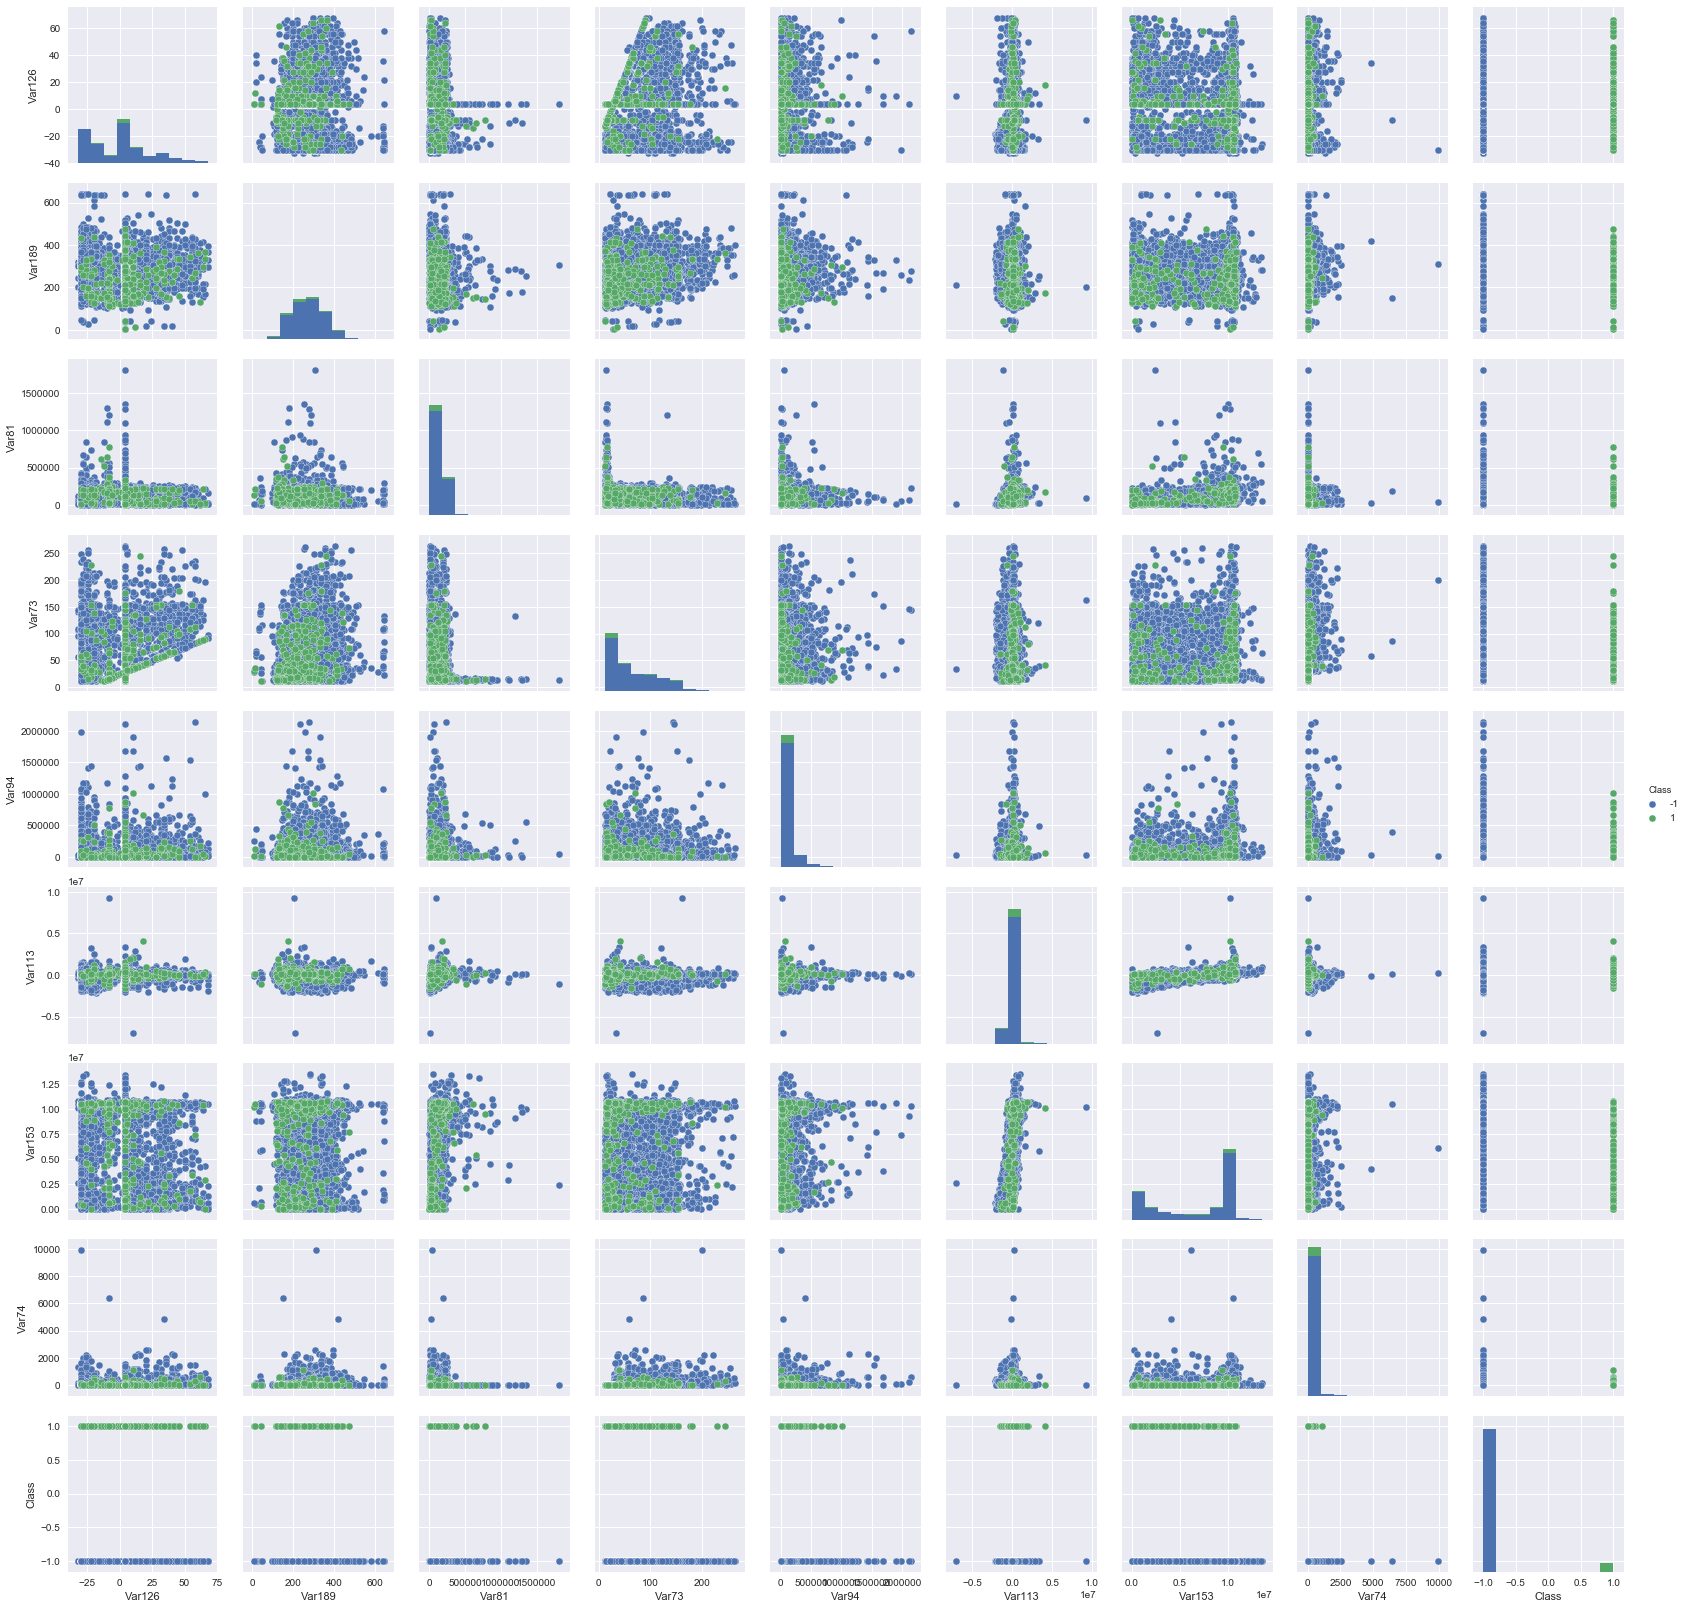

In [309]:
sb.pairplot(train_data[num_max_important_src+['Class']].dropna(), hue='Class')

По крайней мере, области точек разных классов достаточно хорошо различимы на графиках, хотя, как мы и говорили во время предварительного анализа данных, скорее можно выделить области без оттока, чем области с оттоком.

### Выводы

Таким образом, наилучшей моделью оказался градиентный бустинг, подготовка данных выполнена при помощи устранения констатных столбцов, замены в числовых признаках пропущенных значений на 0 и их стандартизацией, а также преобразованием категориальных признаков в числовые методом OneHotEncoder и балансировки путем UnderSampling'а. Параметры: n_estimators = 125, max_depth=2, min_sample_leaf = 50.
Отправленный на kaggle результат составил roc_auc = 0.69300 . Интересно, что на обучающей выборке, а также на отложенной выборке эта модель давала около 0.72775... Почему на выборке Kaggle такое отставание - непонятно.

Также пока не объясненной неожиданностью стало то, что на самом деле немного лучшей оказалась модель градиентного бустигша без балансировки классов вообще, но на попытке предсказать отток на выборке Kaggle она выдала всего 3 варианта оттока, то есть, по сути, не предоложила оттока вообще. Стоит заменить обработку данных, например, на UnderSampling, и результаты сразу появляются. Загадка. На кросс-валидации и отложенной выборке такого не наблюдается...

P.S. Одной из неодназначнейших задач оказался выбор модели. Обычно советуют использовать кросс-валидацию или отоженную выборку. В нашей же работе есть и то, и другое. Причем построенная выбранная на кросс-валидации модель далеко не так здорово ведет себя на отложенной выборке, но и сама отложенная выборка тоже, ведь, не эталон. Поэтому все способы преобразования данных и оптимизации моделей оценивались сразу и по кросс-валидации, и по отложенной выборке для чего они ранжировались по кросс-валидации и ранжировались по отложенной выборке - потом ранги складывали и у кого окажется меньше, тот и выиграл (если оказались одинаковыми, то предпочтение отдается варианту, показавшему лучший вариант на отложенной выборке, т.к. отложенная выборка - это эмитация дальнейшей оценки на тестовой выборке Kaggle).